# Online Sales prediction

This project  aims to predict online retails sales of a multi vendor store using machine  learnong techniques, in python language

The data used in this project is from an online multi  vendor store, located in Barzil, for the brazilian market, named Olist. Their data  of salea for the period of 01/2017 – 07/2018 the fully published on kaggle
https://www.kaggle.com/olistbr/brazilian-ecommerce


In [1]:
#basics
import numpy as np
import pandas as pd


#data setting preprocessing and such
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from sklearn.model_selection import train_test_split
import sklearn.metrics as sm
import ast
import datetime as dt


# plotting and graphing
import matplotlib.pyplot as plt


# modeling
from sklearn.cluster import KMeans
#from sklearn.cluster import DBSCAN
# model validating
from sklearn.metrics import silhouette_score
import fbprophet as pp

In [2]:
# https://www.officeholidays.com/countries/brazil/2017

### Global vars and consts settings

In [3]:
basefolder = "/kaggle/input/brazilian-ecommerce/"
# declaring
# life the universe and everything
random_state = 42
# first contact day
start_date = dt.datetime(2063, 4, 5)
end_date = dt.datetime(2063, 4, 5)
model_now = dt.datetime(2063, 4, 5)
prod_pred = pd.DataFrame()

In [4]:
global_err = pd.DataFrame()

In [5]:
# future class cats, now global label variables
cats = [] # should be pcats
sellersCats = []
ddLE = defaultdict(LabelEncoder)

### Functions implementations

In [6]:
def fillDf(df):
    df.update(df.select_dtypes(include=[np.number]).fillna(0))
    df.update(df.select_dtypes(include='object').fillna('0'))
    return df

In [7]:
def pivotSequence(df, ts_col, start_date, end_date, days, col_to_group, col_to_agg, action = 'count'): #timePeriod to slice by, by days
    """returns data aggregated by the function, pivoted, by the selected index
        parameters:
        df - the dataframe to process
        ts_col - the timestamp column by which to slice the df
        start_date - the start date
        end_date - the end date
        days - the number of days to slice by
        colToGroup - the column to group by
        col_to_agg - the column to aggregate
        action - the group action, default 'count'
    """
    #validate df as DataFrame
    # validate start_date, end_date as date
    #validate days as integer
    #validate colToGroup,col_to_agg as string
    try:
        end_date = pd.to_datetime(end_date)
        iterator = pd.to_datetime(start_date)
        delta = dt.timedelta(days=days)
    except:
        return -1
    
    n = 0
    grped = pd.DataFrame()
    retpd = pd.DataFrame(columns = [col_to_group])
    retpd.set_index(col_to_group,inplace = True)
    
    while iterator <= end_date:
        n = n + 1
        grped = df[(df[ts_col] >= iterator) & (df[ts_col] < iterator + delta)].groupby(col_to_group).aggregate({col_to_agg:action})

        grped.columns = [n]
        retpd = pd.merge(grped, retpd, how='outer', left_index=True, right_index=True)
        
        iterator += delta
        iterator = pd.to_datetime(iterator)
        
        
    retpd.reset_index(inplace=True)
    retpd.fillna(0, inplace = True)

    return retpd

In [8]:
# Generates order items per per X, where is an aggregate by object: sellers, customers or products
# we need this as a function to be flexible for various training and testing data
# the main feature engineering code...
def createOipx(oi, lefter, start_date,end_date, newCats=False,merge_on='product_id',strliaze='product_category_name',date_filter='order_purchase_timestamp', group_by="'price':'min','freight_value':'mean','product_category_name':'min','product_name_length':'min','product_photos_qty':'mean','product_weight_g':'mean','product_height_cm':'mean','product_width_cm':'min','product_length_cm':'min'"):
    """
    createOipx(lefter, start_date,end_date, newCats=False,merge_on='product_id',strliaze='product_category_name',date_filter='shipping_limit_date', group_by="'price':'min','freight_value':'mean','product_category_name':'min','product_name_length':'min','product_photos_qty':'mean','product_weight_g':'mean','product_height_cm':'mean','product_width_cm':'min','product_length_cm':'min'"):
    creates a dedicated Dataframe for the anlysis of Order Items Per X, where X is seller, product or customer
    
        good for setting training and testing for various periods, for various objects
    
    oi - our local version of order_items - basically the righter, (even thuogh it's the first parameters...)
    lefter - the dataframe to which we want to join the order items (i.e seller, product or customer)
    since
    
    """
    #local var declaration
    newOipp = pd.DataFrame() # the 1st return var
    sales_per_week = pd.DataFrame() # an intermediary variable
    newGrpp = pd.DataFrame() # the 2nd return var
    tmp = []
    
    newOipp = pd.merge(lefter,oi, how="left", on=merge_on)
    
    newOipp[date_filter] = pd.to_datetime(newOipp[date_filter])
    newOipp = newOipp[(newOipp[date_filter] >= start_date) & (newOipp[date_filter] < end_date)]
    newOipp[strliaze] = newOipp[strliaze].astype(str)
    
    #carefulness is required - the initial dataset that will generate the labale encoding needs to be robust enough !
    newOipp = catLoader(newOipp,newCats)
    
    delta = end_date - start_date
    delta = delta.days # + 1 or  -1
    
    tmp = list(np.arange(1,np.ceil(delta / 7)))
    sales_per_week = pivotSequence(newOipp,date_filter,start_date,end_date,7,merge_on,'order_id','count')
    
    newOipp = pd.merge(newOipp, sales_per_week, how='left',on=merge_on)
    #tmp = list(np.arange(1,8))
    tmp = [str(item) for item in tmp]
    tmp = ":'mean',".join(tmp)
    #group_by += ",'" + date_filter + "': [np.min, np.max]'"
    paramsdict = "{" + group_by + "," + tmp + ":'mean'}"
    paramsdict = ast.literal_eval(paramsdict)
    #1:'mean',2:'mean',3:'mean',4:'mean',5:'mean',6:'mean',7:'mean',8:'mean',9:'mean'}
    newGrpp = newOipp.groupby(merge_on).aggregate(paramsdict)
    

    ####to calculate merge_on's lifetime, average quantity per date??
    tmp = newOipp.groupby(merge_on).aggregate({ date_filter : [np.min, np.max]})
    tmp.columns = ['min_sale_date','max_sale_date']
    tmp['lifetime'] = (tmp['max_sale_date'] - tmp['min_sale_date']).dt.days
    tmp['is_active'] = ((end_date - tmp['max_sale_date']).dt.days < 30)*1
    tmp['max_sale_date'] = (model_now - tmp['max_sale_date']).dt.days
    tmp['min_sale_date'] = (model_now - tmp['min_sale_date']).dt.days
    tmp.rename(columns={'max_sale_date':'age_of_last_sale','min_sale_date':'age'}, inplace=True)
    
    newGrpp = pd.merge(newGrpp,tmp,left_index=True, right_index=True,how='left')
    
    tmp = newOipp[newOipp[date_filter] >= (end_date - dt.timedelta(30))].groupby(merge_on).aggregate({ 'price' : 'sum'})
    tmp.columns = ['last_30_days_sales']
    
    tmp2_1 = newOipp[(newOipp[date_filter] < (end_date - dt.timedelta(30))) & (newOipp[date_filter] >= (end_date - dt.timedelta(60)))].copy()
    tmp2 = tmp2_1.groupby(merge_on).aggregate({ 'price' : 'sum'})
    tmp2.columns = ['before_last_30_days_sales']
    
    tmp = pd.merge(tmp,tmp2,left_index=True, right_index=True,how='inner')
    tmp['trend'] = round((tmp['last_30_days_sales'] / tmp['before_last_30_days_sales']) - 1,2)
    tmp.drop(tmp.columns.difference([merge_on,'trend']), axis=1, inplace=True)
    newGrpp = pd.merge(newGrpp,tmp,left_index=True, right_index=True,how='left')
        
    newOipp = fillDf(newOipp)
    newGrpp = fillDf(newGrpp)
    
    return newOipp, newGrpp

In [9]:
def fillMissingDates(inputDf,date_filter,start_date,end_date,specs_fill={}):
    
    returnDf = pd.DataFrame()
    returnDf = inputDf.copy()
        # missing dates filling
    delta = end_date - start_date
    delta = delta.days # + 1 or  -1
    
    returnDf['date_with_suffix_so_no_way_someone_will_input_this_column_name_and_f_ing_break_it'] = pd.to_datetime(returnDf[date_filter]).dt.date
    returnDf['date_with_suffix_so_no_way_someone_will_input_this_column_name_and_f_ing_break_it'] = pd.to_datetime(returnDf['date_with_suffix_so_no_way_someone_will_input_this_column_name_and_f_ing_break_it'])
    
    datelist = pd.DataFrame(pd.date_range(start_date, periods=delta))
    datelist.columns = ['date_with_suffix_so_no_way_someone_will_input_this_column_name_and_f_ing_break_it']
    datelist['date_with_suffix_so_no_way_someone_will_input_this_column_name_and_f_ing_break_it'] = pd.to_datetime(datelist['date_with_suffix_so_no_way_someone_will_input_this_column_name_and_f_ing_break_it'])
    
    returnDf = pd.merge(datelist,returnDf,how='left',on='date_with_suffix_so_no_way_someone_will_input_this_column_name_and_f_ing_break_it')
    
    returnDf[date_filter].fillna(returnDf['date_with_suffix_so_no_way_someone_will_input_this_column_name_and_f_ing_break_it'],inplace=True)
    returnDf.drop(['date_with_suffix_so_no_way_someone_will_input_this_column_name_and_f_ing_break_it'],axis=1, inplace=True)
    for key, value in specs_fill.items():
        returnDf[key].fillna(value,inplace=True)
    
    returnDf = fillDf(returnDf)
    
    return returnDf

In [10]:
## this and it's following both work on the same variables, which are global
## bottom line, they better both be a part of a class together with the vars, maybe in a future version
def catEncoder(oipx0,runOver=False):
    oipx = pd.DataFrame()
    oipx = oipx0.copy()
    #variables declaration
    fit = pd.DataFrame()
    global cats
    global ddLE
    local_cats = []
    global_cats = []
    
    for col in oipx.columns:
        if oipx[col].dtype == 'O':
            local_cats.append(col)

 # or, better, a more specific error (or errors)
    removables = ['product_id','order_id', 'seller_id','customer_id','customer_unique_id']
    # global var #1 setting - cats
    for removable in removables:
        try:
            local_cats.remove(removable)
        except Exception:
            pass
    
    
    # runOver - allows us run over existing label encoder and run over existing ones
    # I hate too many ifs... a program should flow
    if (not(runOver)):
        for global_cat in cats:
            if (global_cat in local_cats):
                global_cats.append(global_cat)
                local_cats.remove(global_cat)
    
    fit[global_cats] = oipx[global_cats].apply(lambda x: ddLE[x.name].transform(x))
    fit[local_cats] = oipx[local_cats].apply(lambda x: ddLE[x.name].fit_transform(x))
    for cat in (local_cats + global_cats):
        oipx[cat] = fit[cat]
        
    local_cats = local_cats + global_cats
    cats = list(set(cats) | set(local_cats))
    
    return oipx

def catLoader(oipx0,newCats=False):
    oipx = pd.DataFrame()
    oipx = oipx0.copy()
    #local variable declaration
    fitreal = pd.DataFrame()
    global ddLE
    local_cats = []

    for col in oipx.columns:
        if oipx[col].dtype == 'O':
            local_cats.append(col)

    
    #if the label encoder is already set - call the existing labels to set the Oipp cats
    #if there are none, encode a new one.
    if ((local_cats) or (newCats)):
        return catEncoder(oipx)
    else:
        fitreal = oipx[local_cats].apply(lambda x: ddLE[x.name].transform(x))
        for cat in local_cats:
            oipx[cat] = fitreal[cat]

        return oipx
    

In [11]:
def predict(train0,col_to_agg,action,group_date,test_start_date,test_end_date,interval_width=0.8,outliers=True,regressor=pd.DataFrame()): #,graphs=False
    prediction = pd.DataFrame()
    train = pd.DataFrame()
    train = train0.copy() # It seems that paramters are passed by reference (face-palm)
    delta = test_end_date - test_start_date
    periods = delta.days + 10
    
    if (train.shape[0] == 0):
        return prediction
    
    train[group_date] = pd.to_datetime(train[group_date]).dt.date.copy()
    train = train.groupby(group_date).agg({col_to_agg:action})
    train.reset_index(inplace=True)
    train.columns = ['ds','y']
    
    if (not(outliers)):
        train = unOutlierOnTop(train,'y')
    
    reg_cols = []
    if (not(regressor.empty)): ##
        train = pd.merge(train,regressor[(regressor['ds'].dt.date < test_start_date.date())],on='ds',how='left')
        regressor.drop(['ds'],axis=1,inplace=True)
        reg_cols = regressor.columns
        tsModel = pp.Prophet(yearly_seasonality=True,weekly_seasonality=True,daily_seasonality=True,interval_width=interval_width,regressor=regressor) # ,holidays=brazil_holidays the holidays actually make the prediction worse...
    else:
        tsModel = pp.Prophet(yearly_seasonality=True,weekly_seasonality=True,daily_seasonality=True,interval_width=interval_width) # ,holidays=brazil_holidays the holidays actually make the prediction worse...
    
    
    for col in reg_cols:
        tsModel.add_regressor(col)
        
    tsModel.fit(train) # the actual training
    future = tsModel.make_future_dataframe(periods=periods) # presetting the timeseries dataframe for testing
    if (not(regressor.empty)):
        future = pd.merge(future,regressor[(regressor['ds'].dt.date >= test_start_date.date() & regressor['ds'].dt.date <= test_end_date.date())],on='ds',how='left')
    
    forecast = tsModel.predict(future)
    
    graphs = False
    if (graphs):
        figp = tsModel.plot_components(forecast)
    
    #prediction = forecast[(forecast['ds'] >= test_start_date) & (forecast['ds'] < test_end_date)]
    prediction = forecast[(forecast['ds'] < test_end_date)] # (forecast['ds'] >= test_start_date) &
    prediction.set_index('ds',inplace=True)
    #fig = tsModel.plot_components(forecast)
    
    return prediction

In [12]:
def fit_predict(train,filter_date='order_purchase_timestamp',col_to_agg='price',action='sum',outliers=True,regressor=pd.DataFrame()): #,graphs=False
    # works on quite a few global vars, kind of says - class, but in future versions...
    global periods
    global start_date
    global end_date
    global test_start_date
    global test_end_date
    
    x_pred = pd.DataFrame()
    tmp = pd.DataFrame()
    
    train[filter_date] = pd.to_datetime(train[filter_date])
    train[filter_date] = train[filter_date].dt.date
    clusters = list(train['cluster'].unique())
    
    
    x_pred = pd.DataFrame(pd.date_range(test_start_date, periods=periods))
    x_pred.columns = ['ds']
    x_pred.set_index('ds', inplace=True)

    for i in clusters:
        tmp = train[train['cluster'] == i].copy()

        if (tmp.shape[0] > 2):
            tmp = fillMissingDates(tmp,filter_date,start_date,end_date)
        #try:
        prd = predict(tmp,col_to_agg=col_to_agg,action=action,group_date=filter_date,test_start_date=test_start_date,test_end_date=test_end_date,outliers=outliers,regressor=regressor)['yhat'] #,graphs=False
        x_pred[i] = prd
       # except:
       #     print('cluster....: ' + str(i))
       #     print('banged!')

    x_pred['total'] = x_pred.sum(axis=1)
    return x_pred

In [13]:
def easterEgg():
    print('Im weighing it')
    print('...')
    import time
    time.sleep(3)
    print('50 gramms')

In [14]:
def edapx(grpx,object_name='x'):
    
     
    num_bins = 50
    fig, ax = plt.subplots(1,1, tight_layout = True)
    ax.hist(grpx['age_of_last_sale'], num_bins)
    fig.tight_layout()
    plt.title('time from the last sale, per ' + object_name)
    plt.show()


    num_bins = 50
    fig, ax = plt.subplots(1,1, tight_layout = True)
    ax.hist(grpx['lifetime'], num_bins)
    fig.tight_layout()
    plt.title('Lifetime distribution for ' + object_name)
    plt.show()

    num_bins = 50
    fig, ax = plt.subplots(1,1, tight_layout = True)
    ax.hist(grpx['lifetime'][grpx['lifetime'] > 0], num_bins)
    fig.tight_layout()
    plt.title('Lifetime distribution for returning ' + object_name)
    plt.show()
    
    num_bins = 50
    fig, ax = plt.subplots(1,1, tight_layout = True)
    ax.hist(grpc0['price'], num_bins)
    fig.tight_layout()
    plt.title('Average purchase distribution per customers')
    plt.show()

In [15]:
# EDA per x
def edapx_clustered(grpx,object_name='x'):
    

    tmp = pd.DataFrame()
    tmp['cluster'] = grpx['cluster'].copy()
    lbls = list(tmp['cluster'].unique())
    
    # simple pie chart    
    tmp = tmp.groupby('cluster')['cluster']
    plt.pie(tmp.count(),labels = lbls)
    plt.title(object_name + ' distribution by cluster')
    plt.show()
    
    # sales count
    tmp = grpx.groupby('cluster').agg({'price':'count'})
    plt.figure()
    plt.barh(lbls,tmp['price'])
    plt.title(object_name + ' total sales count per cluster')
    plt.show()
    
    # average sale amount
    tmp = grpx.groupby('cluster').agg({'price':'mean'})
    plt.figure()
    plt.barh(lbls,tmp['price'])
    plt.title(object_name + ' total sales mean per cluster')
    plt.show()
    
    # average lifetime
    tmp = grpx.groupby('cluster').agg({'lifetime':'mean'})
    plt.figure()
    plt.barh(lbls,tmp['lifetime'])
    plt.title(object_name + ' lifetime per cluster')
    plt.show()
    
    #add_split


In [16]:
def countUniqueX(df, ts_col,start_date, end_date, col_to_work):
    # This function can be generelized more but it's only set as a function to save multiple calling of the code
    #pivotSequence(df, ts_col, start_date, end_date, days, colToGroup, col_to_agg, action = 'count')
    # local var declaration
    unique_count = pd.DataFrame()
    unique_count = pivotSequence(df, ts_col, start_date, end_date, 1, col_to_work, col_to_work, action = 'count')
    unique_count.set_index(col_to_work,inplace=True)
    unique_count[unique_count > 0] = 1
    unique_count = unique_count.sum(axis=0)
    unique_count = pd.DataFrame(unique_count)
    unique_count.reset_index(inplace=True)
    unique_count.columns = ['days_from_start','x_count']
    unique_count['date'] = start_date
    unique_count['date'] = unique_count['date'] + pd.TimedeltaIndex(unique_count['days_from_start'], unit='D')
    unique_count['date'] = unique_count['date'] - dt.timedelta(days=1)
    
    return unique_count

In [17]:
def countUniqueXPerCluster(df,cluster_col,idx,ts_col):
    result = pd.DataFrame()
    for i in df[cluster_col].unique():
        temp = df[df[cluster_col] == i][[idx,ts_col]]
        res = countUniqueX(temp,ts_col,start_date, end_date,idx)
        res[cluster_col] = i
        result = pd.concat([result,res],ignore_index=True)
    result['date']  = pd.to_datetime(result['date'])
    return result

In [18]:
def x_elbow(grpx,range0=np.arange(2,10)):
    distortions = []
    silhuettes = []

#K = range(1,10)
    for k in range0:
        x_cluster = KMeans(n_clusters=k,init='k-means++', n_init=20, random_state=random_state,max_iter=400)
        x_cluster.fit(grpx)
        distortions.append(x_cluster.inertia_)
        silhuettes.append(silhouette_score(grpx, x_cluster.labels_, metric='euclidean'))

    #https://matplotlib.org/2.2.5/gallery/api/two_scales.html
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('k')
    ax1.set_ylabel('Distortion', color=color)
    ax1.plot(range0, distortions, 'bx-')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('silhuette score', color=color)  # we already handled the x-label with ax1
    ax2.plot(range0, silhuettes, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    
    return distortions, silhuettes

In [19]:
def unOutlierOnTop(df,value_col):
    q1 = df[value_col].quantile(0.25)
    q3 = df[value_col].quantile(0.75)
    threshold = q3 + 1.5 * (q3 - q1)
    df.loc[df[value_col] > threshold,value_col] = threshold
    
    return df

In [20]:
def train_test_metrices(test,pred, x_axis): #each parameter is a series
        #ret = pd.DataFrame()
        #ret['']
        #yes, counld have been a dictionary....
        ret = []
        ret.append(round(sm.mean_absolute_error(test, pred),2))
        ret.append(round(np.sqrt(sm.mean_squared_error(test, pred)),2))
        ret.append(round(sm.median_absolute_error(test, pred),2))
        ret.append(round(sm.explained_variance_score(test, pred),2))
        ret.append(round(sm.r2_score(test, pred),2))
        retdesc = ["mean absolute error: ","root mean squared error: ","median absolute error: ","explained variance score: ","r2 score: "]
        
        print('prediction vs test')
        for i in np.arange(0,5):
            print(retdesc[i], ret[i])
        #print("mean absolute error: ", round(sm.mean_absolute_error(test, pred),2))
        #print("root mean squared error: ", round(np.sqrt(sm.mean_squared_error(test, pred)),2))
        #print("median absolute error: ", round(sm.median_absolute_error(test, pred),2))
        #print("explained variance score: ", round(sm.explained_variance_score(test, pred),2))
        #print("r2 score: ", round(sm.r2_score(test, pred),2))
        
        #plt.bar(courses, values, color ='maroon', width = 0.4)
        plt.figure(figsize=(12, 6))
        plt.plot(x_axis,test, label='test',color ='maroon')
        plt.plot(x_axis,pred, label='prediction')
        plt.show()
        
        return ret

In [21]:
def printGraphs(df,x_axis_col):
    cols = list(df.columns)
    cols.remove(x_axis_col)
    
    plt.figure(figsize=(12, 6))
    
    for col in cols:
        plt.plot(df[x_axis_col],df[col], label=col)
    plt.show()
    

In [22]:
def yearMonth(odf,date_grouper,action):
    df = pd.DataFrame()
    df = odf.copy()
    df['yearMonth'] = df[date_grouper].dt.year*100 + df[date_grouper].dt.month
    df.drop(date_grouper, axis=1,inplace=True)
    cols = list(df.columns)
    cols.remove('yearMonth')
    agg_params = dict.fromkeys(cols,action)
    df = df.groupby('yearMonth').agg(agg_params)

    return df

### Data Loading

In [23]:
customers = pd.read_csv(basefolder +'olist_customers_dataset.csv')
geo = pd.read_csv(basefolder +'olist_geolocation_dataset.csv')
order_items = pd.read_csv(basefolder +'olist_order_items_dataset.csv')
order_payments = pd.read_csv(basefolder +'olist_order_payments_dataset.csv')
order_reviews = pd.read_csv(basefolder +'olist_order_reviews_dataset.csv')
orders = pd.read_csv(basefolder +'olist_orders_dataset.csv')
products = pd.read_csv(basefolder +'olist_products_dataset.csv')
sellers = pd.read_csv(basefolder +'olist_sellers_dataset.csv')

pcat = pd.read_csv(basefolder +'product_category_name_translation.csv')
#holidays = pd.read_csv(basefolder +'brazil_holidays.csv')

## Quick view and arranging  the data

Products viewing and arranging

1st of all, this columns name is very annoying! <span style="font-style: italic;">product_description_lenght</span>

In [24]:
products.rename(columns = {'product_name_lenght': 'product_name_length'},inplace=True) # too annoying to read !

next

In [25]:
pcat.head()

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [26]:
print('the product categories from the products table: '  + str(products[['product_category_name']].nunique()))
print('the product categories from the products categories table: '  + str(pcat[['product_category_name']].nunique()))

the product categories from the products table: product_category_name    73
dtype: int64
the product categories from the products categories table: product_category_name    71
dtype: int64


There's a slight difference, which is strange, and might imply that both categoroeis list don't fully overlap

In [27]:
missing_products = products[['product_category_name']]
missing_products = pd.DataFrame(missing_products['product_category_name'].unique())
missing_products.columns = ['product_category_name']
missing_products['product_category_name_english'] = missing_products['product_category_name'].copy()

In [28]:
pcat = pd.concat([pcat, missing_products])
pcat.drop_duplicates(inplace=True)

done with that - let's encode the categories, to have the same categories for any encoding

In [29]:
pcat0 = pcat
pcat.loc[pcat.shape[0]] = ['0','0']
catEncoder(pcat)

,product_category_name,product_category_name_english
0,12,83
1,45,35
2,9,13
3,14,18
4,55,79
...,...,...
70,66,120
71,68,123
72,53,102
73,18,28


NULL checking

In [30]:
products.isna().any()

product_id                    False
product_category_name          True
product_name_length            True
product_description_lenght     True
product_photos_qty             True
product_weight_g               True
product_length_cm              True
product_height_cm              True
product_width_cm               True
dtype: bool

all of the products features can be filled with zeros, either as strings or as integers. there's no meaning for average

In [31]:
products = fillDf(products)

Sellers viewing and arranging

In [32]:
sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


not too many sellers features... only location data <br>
in nay case, let's encode in advance

In [33]:
tmp = pd.DataFrame(sellers['seller_state'].unique())
tmp.loc[tmp.shape[0]] = ['0']
tmp.columns = ['seller_state']
catEncoder(tmp,runOver=True)
tmp = pd.DataFrame(sellers['seller_city'].unique())
tmp.loc[tmp.shape[0]] = ['0']
tmp.columns = ['seller_city']

Customers viewing and arranging

In [34]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


like the sellers, nothing too special but location data <br>
But's there a mine here... <span style="font-style:italic">customer_unique_id</span> implies that the customer_id is a "stupid index" not referring to the customer, unlike the product_id or seller_id <br>
<span style="font-style:italic">(why stick a mine there ? a joke by their DBA ... ?)</span><br>
so, whenever we stumple upon the customer_id, we'll need to join the customer_unique_id


In [35]:
tmp = pd.DataFrame(customers['customer_state'].unique())
tmp.loc[tmp.shape[0]] = ['0']
tmp.columns = ['customer_state']
catEncoder(tmp,runOver=True)
tmp = pd.DataFrame(customers['customer_city'].unique())
tmp.loc[tmp.shape[0]] = ['0']
tmp.columns = ['customer_city']

Orders and Order items viewing and arranging

In [36]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


a lot of interesting information, mostly delivery stages dates <br>
the foreign keys for customers and orders <br>
and our first mine hit...

In [37]:
orders0 = orders.copy() # a backup of the original dataset, though we do have it on file...
orders = pd.merge(orders, customers[['customer_id','customer_unique_id']],how='left',on='customer_id')

In [38]:
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


the actual details of each order, where the products and sellers connection lies... what we need for it more is the order purchase date, the foreign keys and maybe the state of sale

In [39]:
order_items = pd.merge(order_items,orders[['order_id','customer_id','customer_unique_id','order_purchase_timestamp']],how='left',on='order_id')
order_items = pd.merge(order_items,sellers[['seller_id','seller_state']],how='left',on='seller_id')
#order_items.drop(['seller_zip_code_prefix','seller_city','shipping_limit_date','order_approved_at','order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date'],axis=1, inplace=True) #'order_purchase_timestamp','order_approved_at','order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date'
#order_items.drop(['order_status'],axis=1,inplace=True)
order_items['order_purchase_timestamp'] = pd.to_datetime(order_items['order_purchase_timestamp'])

Other stuff

In [40]:
geo.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


unless we do a GIS analysis, which is not intended, then there's no extra value in this data

## Data presentation

### Sales trend on a linear graph

quickly viewing how the data looks

In [41]:
oiCust = order_items #pd.merge(order_items,orders,how='inner',on='order_id')
oiCust.head()
oiCust = pd.merge(oiCust,customers,how='inner',on='customer_unique_id')
oiCust['order_purchase_timestamp'] = pd.to_datetime(oiCust['order_purchase_timestamp'])
oiCust['yearmonth'] = oiCust['order_purchase_timestamp'].dt.year*100 + oiCust['order_purchase_timestamp'].dt.month

In [42]:
aggSalesPerDay = oiCust
aggSalesPerDay.head()
aggSalesPerDay['order_purchase_timestamp'] = pd.to_datetime(aggSalesPerDay['order_purchase_timestamp'])
aggSalesPerDay['o_date'] = aggSalesPerDay['order_purchase_timestamp'].dt.date

In [43]:
aggSalesPerDay = aggSalesPerDay.groupby('o_date').agg({'order_item_id': 'count','price':'sum','customer_unique_id': lambda x: x.nunique(),'seller_id': lambda x: x.nunique(),})
aggSalesPerDay.columns = ['sales_count','sales_sum','customer_count','sellers_count']
aggSalesPerDay.reset_index(inplace=True)
aggSalesPerDay['MeanSale'] = round(aggSalesPerDay['sales_sum'] / aggSalesPerDay['sales_count'],2)

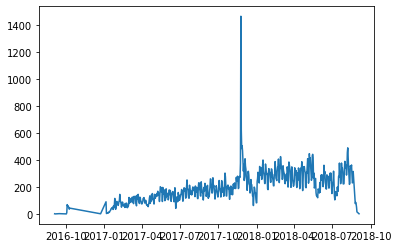

In [44]:
plt.plot(aggSalesPerDay['o_date'], aggSalesPerDay['sales_count'])
plt.show()

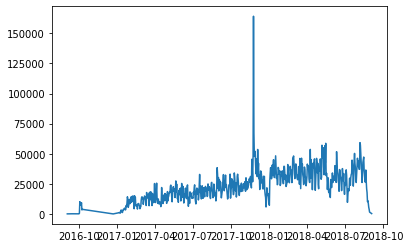

In [45]:
plt.plot(aggSalesPerDay['o_date'], aggSalesPerDay['sales_sum'])
plt.show()

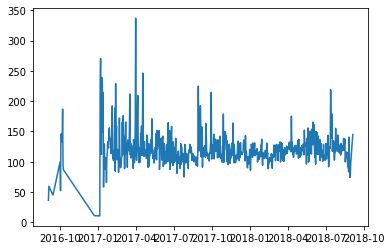

In [46]:
plt.plot(aggSalesPerDay['o_date'], aggSalesPerDay['MeanSale'])
plt.show()

Looking at the sales counts and sum over time we can see: <br>
<ul>
    <li>junk at the graphs edges, meaning we'll need to slice it to work on it</li>
    <li>a general trend inside of which a smaller pulse, probably a weekly trend, and a huge unrelated surge </li>
</ul>
<br>
Let's specifiy a work date range:

In [47]:
working_start_date = dt.datetime(2017, 1, 1)
working_end_date = dt.datetime(2018, 7, 1)

let's slice the order_items data to work with

In [48]:
order_items = order_items[((order_items['order_purchase_timestamp'].dt.date >= working_start_date.date()) & (order_items['order_purchase_timestamp'].dt.date < working_end_date.date()))]

#### unique sellers, customers and product

##### (from this point onwards, regarding any preset function to facilitate the process, we can simply say: by coincidence I have prepared in advance)

Over time

In [49]:
unique_sellers = countUniqueX(order_items[['seller_id','order_purchase_timestamp','price']],'order_purchase_timestamp',working_start_date, working_end_date,'seller_id')
unique_sellers.head(2)

,days_from_start,x_count,date
0,547,0.0,2018-07-01
1,546,113.0,2018-06-30


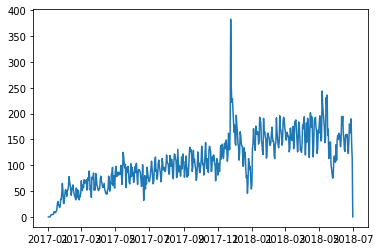

In [50]:
plt.plot(unique_sellers['date'], unique_sellers['x_count'])
plt.show()

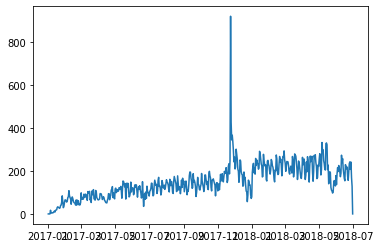

In [51]:
unique_products = countUniqueX(order_items[['product_id','order_purchase_timestamp','price']],'order_purchase_timestamp',working_start_date, working_end_date,'product_id')
plt.plot(unique_products['date'], unique_products['x_count'])
plt.show()

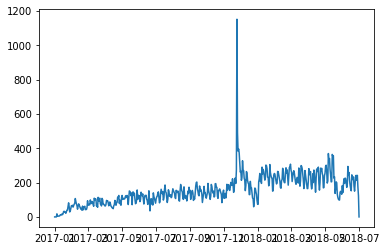

In [52]:
unique_customers = countUniqueX(order_items[['customer_unique_id','order_purchase_timestamp','price']],'order_purchase_timestamp',working_start_date, working_end_date,'customer_unique_id')
plt.plot(unique_customers['date'], unique_customers['x_count'])
plt.show()

All over time trends behave in a very similar fashion
the outlier shows up every time

Let's see how does the data look without outliers - let's slice each outlier at the outlier threshold

In [53]:
# by this definition
# https://en.wikipedia.org/wiki/Outlier

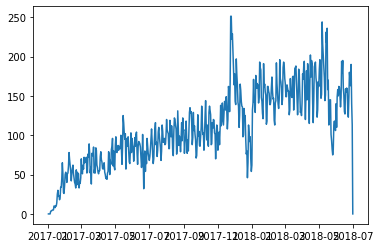

In [54]:
unique_sellers = unOutlierOnTop(unique_sellers,'x_count')
plt.plot(unique_sellers['date'], unique_sellers['x_count'])
plt.show()

Looks much more ordered and trendy
Important ! - if we're to predict any sort of future, and we have this in our past data, we'll need to see if it helps our prediction or not

### main goal KPIs

Business issue to resolves:
recognizing the trend of revenues and product sales and prepare the appropriate budget

As a marketplace, we expect various trends to appear in the data, based on products, customers and sellers

In [55]:
oiCust['dte'] = oiCust['order_purchase_timestamp'].dt.date
oiCust['dte'] = pd.to_datetime(oiCust['dte'])
test47 = oiCust.groupby('dte').agg({'customer_unique_id': lambda x: x.nunique(),'seller_id': lambda x: x.nunique(),'product_id': lambda x: x.nunique()})
test47.reset_index(inplace=True)
#test47['yearmonth'] = test47['dte'].dt.year*100 + test47['dte'].dt.month
test47 = yearMonth(test47,'dte','mean')
test47.tail()
#test47.set_index('yearmonth',inplace=True)


,customer_unique_id,seller_id,product_id
yearMonth,,,
201805,220.354839,153.580645,206.322581
201806,204.766667,153.166667,200.533333
201807,201.096774,150.870968,196.677419
201808,222.000000,164.344828,216.551724
201809,1.000000,1.000000,1.000000


In [56]:
grped_oiCust = oiCust.groupby('yearmonth').agg({'product_id': 'count','price':'sum'})
grped_oiCust = pd.merge(grped_oiCust,test47,left_index=True,right_index=True,how='inner')
grped_oiCust.columns = ['SalesCount','SalesSum','CustomersCount','SellersCount','ProductsCount']
grped_oiCust['MeanSale'] = round(grped_oiCust['SalesSum'] / grped_oiCust['SalesCount'],2)
grped_oiCust['SalesPerSeller'] = round(grped_oiCust['SalesSum'] / grped_oiCust['SellersCount'],2)
grped_oiCust['SalesPerCustomer'] = round(grped_oiCust['SalesSum'] / grped_oiCust['CustomersCount'],2)
grped_oiCust['PurchasesPerCustomer'] = round(grped_oiCust['SalesCount'] / grped_oiCust['CustomersCount'],2)

In [57]:
grped_oiCust.T.head(11)

yearmonth,201609,201610,201612,201701,201702,201703,201704,201705,201706,201707,...,201712,201801,201802,201803,201804,201805,201806,201807,201808,201809
SalesCount,6.000000,383.000000,2.0,1125.000000,2082.000000,3231.000000,2885.00,4577.000000,3962.000000,5005.000000,...,6816.000000,8.839000e+03,8486.000000,8.845000e+03,8.529000e+03,8.494000e+03,7515.000000,7550.000000,7717.000000,2.0
SalesSum,267.360000,51197.000000,21.8,130682.530000,258745.940000,400684.440000,388909.09,550178.190000,471154.150000,544012.740000,...,794650.060000,1.017450e+06,917563.480000,1.037129e+06,1.054439e+06,1.056820e+06,910738.880000,950656.930000,903754.640000,290.0
CustomersCount,1.000000,34.000000,1.0,28.037037,61.250000,84.064516,78.90,116.451613,105.566667,126.193548,...,179.838710,2.305806e+02,234.535714,2.297419e+02,2.302667e+02,2.203548e+02,204.766667,201.096774,222.000000,1.0
SellersCount,1.000000,27.222222,1.0,22.074074,49.821429,65.161290,63.00,87.612903,78.966667,90.064516,...,119.935484,1.507097e+02,155.464286,1.559677e+02,1.639333e+02,1.535806e+02,153.166667,150.870968,164.344828,1.0
ProductsCount,1.333333,34.777778,1.0,28.296296,61.357143,83.129032,78.60,116.483871,103.900000,123.741935,...,171.967742,2.199677e+02,221.678571,2.193548e+02,2.214667e+02,2.063226e+02,200.533333,196.677419,216.551724,1.0
MeanSale,44.560000,133.670000,10.9,116.160000,124.280000,124.010000,134.80,120.200000,118.920000,108.690000,...,116.590000,1.151100e+02,108.130000,1.172600e+02,1.236300e+02,1.244200e+02,121.190000,125.910000,117.110000,145.0
SalesPerSeller,267.360000,1880.710000,21.8,5920.180000,5193.470000,6149.120000,6173.16,6279.650000,5966.490000,6040.260000,...,6625.650000,6.751060e+03,5902.090000,6.649640e+03,6.432120e+03,6.881210e+03,5946.060000,6301.130000,5499.140000,290.0
SalesPerCustomer,267.360000,1505.790000,21.8,4661.070000,4224.420000,4766.390000,4929.14,4724.520000,4463.100000,4310.940000,...,4418.680000,4.412560e+03,3912.250000,4.514320e+03,4.579210e+03,4.795990e+03,4447.690000,4727.360000,4070.970000,290.0
PurchasesPerCustomer,6.000000,11.260000,2.0,40.130000,33.990000,38.430000,36.57,39.300000,37.530000,39.660000,...,37.900000,3.833000e+01,36.180000,3.850000e+01,3.704000e+01,3.855000e+01,36.700000,37.540000,34.760000,2.0


In [58]:
grped_oiCust.head(11)

,SalesCount,SalesSum,CustomersCount,SellersCount,ProductsCount,MeanSale,SalesPerSeller,SalesPerCustomer,PurchasesPerCustomer
yearmonth,,,,,,,,,
201609,6,267.36,1.000000,1.000000,1.333333,44.56,267.36,267.36,6.00
201610,383,51197.00,34.000000,27.222222,34.777778,133.67,1880.71,1505.79,11.26
201612,2,21.80,1.000000,1.000000,1.000000,10.90,21.80,21.80,2.00
201701,1125,130682.53,28.037037,22.074074,28.296296,116.16,5920.18,4661.07,40.13
201702,2082,258745.94,61.250000,49.821429,61.357143,124.28,5193.47,4224.42,33.99
201703,3231,400684.44,84.064516,65.161290,83.129032,124.01,6149.12,4766.39,38.43
201704,2885,388909.09,78.900000,63.000000,78.600000,134.80,6173.16,4929.14,36.57
201705,4577,550178.19,116.451613,87.612903,116.483871,120.20,6279.65,4724.52,39.30
201706,3962,471154.15,105.566667,78.966667,103.900000,118.92,5966.49,4463.10,37.53


## Forecasting

#### we need to notice that - if we're predcting trend over time, the calendar year trend is important. right now we have only 1.5 years, and the outlier even happens in the last few days of noevember, within our single calendar year
#### meaning, if we assume that the training is in our past, we'll need to treat this - remove the outliers

In [59]:
#specifying
start_date = dt.datetime(2017, 1, 1)
end_date = dt.datetime(2017, 11, 1)
periods = (end_date - start_date).days + 1
print('train periods: ' + str(periods))

test_start_date = end_date #dt.datetime(2017, 11, 1)
test_end_date = dt.datetime(2018, 7, 1)
model_now = end_date

periods = (test_end_date - test_start_date).days + 1
print('test periods: ' + str(periods))

train periods: 305
test periods: 243


What I need to do is to un-function the prediction...
To predict for each cluster, while I loop on the clusters directly
Then aggregate the results, then compare them to the test data, unclustere
In that way I can add a whole bunch of features for clustering and make it better
I can also be more accurate, I want the total accurate, not my own intermediary cluster

also, I can make a few clustered predictions: by sellers, customers, products, all of them in a single cluster then average the totals predictions then compare it to the test
    run a few clustering models to be added to the pile ?
in my free time I need to learn the prophet model more deeply. anything that I can add ?
  

In [60]:
#oi = order_items[order_items['seller_state'] == state].copy()
prod_pred = pd.DataFrame()
sellers_pred = pd.DataFrame()
avg = pd.DataFrame()
oi = order_items.copy()
oi.drop(['seller_state'],axis=1,inplace=True)

### Data Setting and feature engineering

Our anchor dataset is of order items over time, for each main object: product, customer or seller, we’ll join with order items, then group by the object, trying to get any extra information that we can

So, we got:
<ul>
	<li>The obvious: average sales, total sale count, total sales sum </li>
	<li>more: lifetime, age in the system </li>
	<li>trends: the sales amount per week, for the training period, is the object active (sold in the month), was the object selling more than or less than in the last month in comparison to the previous </li>
 </ul>

In [61]:
group_vars = "'price':'mean','price':'min','freight_value':'mean','product_category_name':'min','product_name_length':'min','product_photos_qty':'mean','product_weight_g':'mean','product_height_cm':'mean','product_width_cm':'min','product_length_cm':'min'"
oipp0, grpp0 = createOipx(order_items,products,start_date,end_date, merge_on='product_id', group_by=group_vars) ###

#customer_zip_code_prefix	customer_city	customer_state
group_vars = "'price':'count','price':'sum','price':'mean','freight_value':'mean','seller_state_x':'min'"
oips0, grps0 = createOipx(order_items, sellers, start_date,end_date, merge_on='seller_id',strliaze = 'seller_state_x', group_by=group_vars)

group_vars = "'price':'count','price':'sum','price':'mean','freight_value':'mean','customer_state':'min','customer_city':'min'" # the stares are label ecustomer_idncoded and will always be the same, so minimize will just select the proper label
oipc0, grpc0 = createOipx(order_items, customers, start_date,end_date, merge_on='customer_unique_id',strliaze = 'customer_state', group_by=group_vars)

In [62]:
grpc0.head()

,price,freight_value,customer_state,customer_city,1.0,2.0,3.0,4.0,5.0,6.0,...,39.0,40.0,41.0,42.0,43.0,age,age_of_last_sale,lifetime,is_active,trend
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
0000f46a3911fa3c0805444483337064,69.00,17.22,24,2503,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,235,235,0,0,0.0
0000f6ccb0745a6a4b88665a16c9f078,25.99,17.63,14,312,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,19,19,0,1,0.0
0005e1862207bf6ccc02e4228effd9a0,135.00,15.12,19,2738,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,241,241,0,0,0.0
0006fdc98a402fceb4eb0ee528f6a8d4,13.90,15.10,8,1645,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,105,105,0,0,0.0
000a5ad9c4601d2bbdd9ed765d5213b3,76.99,14.29,23,2116,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,81,81,0,0,0.0


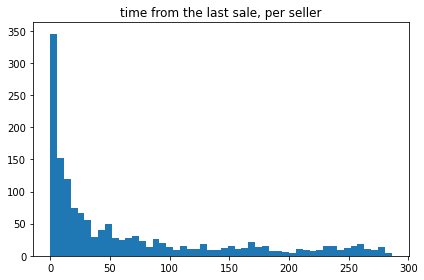

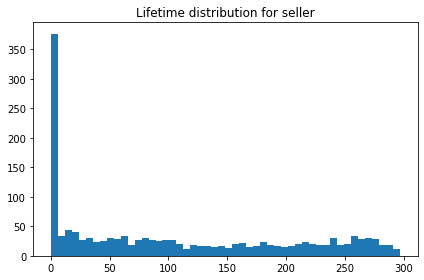

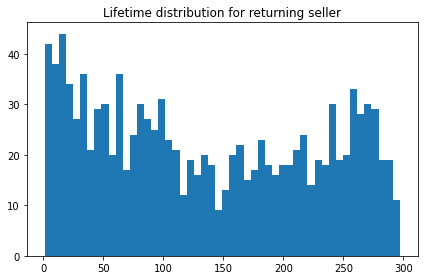

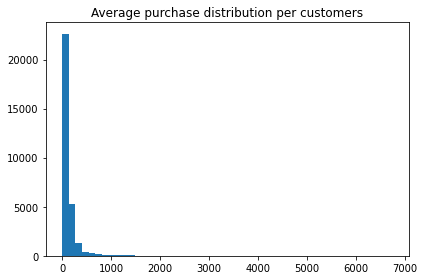

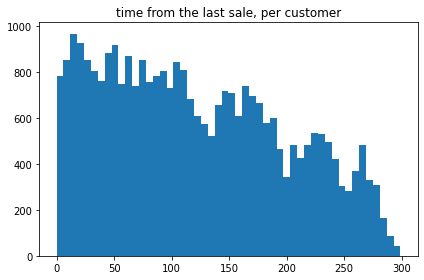

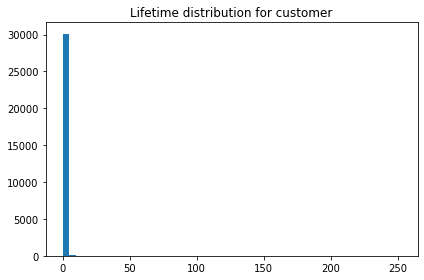

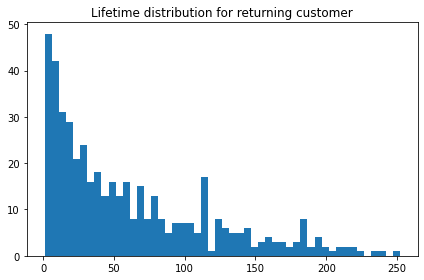

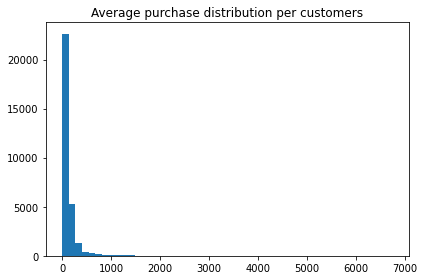

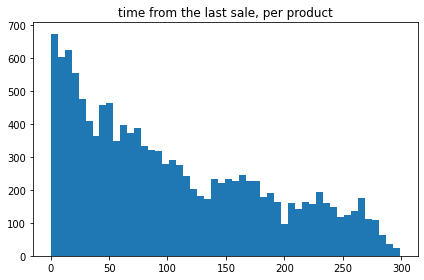

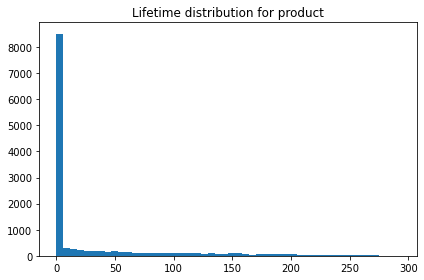

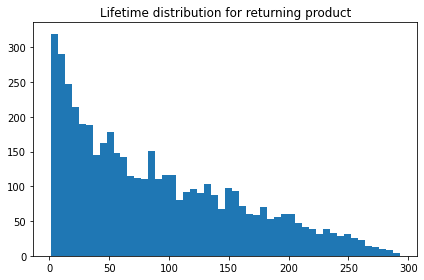

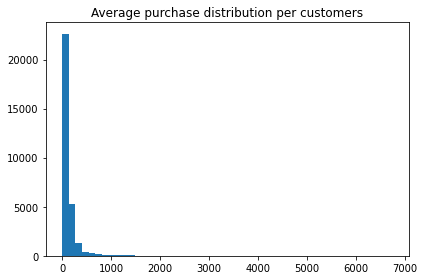

In [63]:
edapx(grps0,'seller')
edapx(grpc0,'customer')
edapx(grpp0,'product')

before we EDA by cluster, and we cluster - then let's find the ideal cluster<br>
we'll check the ideal by looking at the elbow graph... <span style="font-style: italic;">adding a siluette graph, for a second opinion</span>

Distortion and Silhuette - Customers

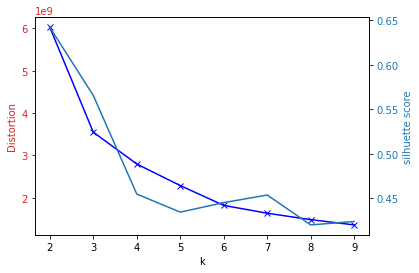

In [64]:
disc, silc = x_elbow(grpc0,range0=np.arange(2,10))

Distortion and Silhuette - Sellers

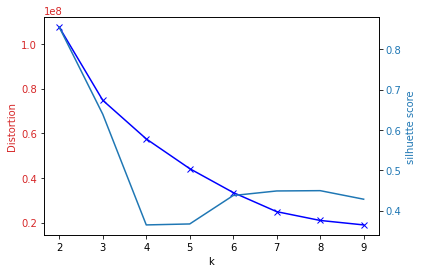

In [65]:
diss, sils = x_elbow(grps0,range0=np.arange(2,10))

Distortion and Silhuette - Products

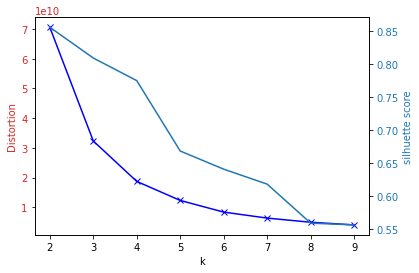

In [66]:
discp, silp = x_elbow(grpp0,range0=np.arange(2,10))

for customer we'll choose 3 clusters, for sellers 3 as well and for products we can take 4
for sellers, this 

In [67]:
customer_cluster = KMeans(n_clusters=3,init='k-means++', n_init=20, random_state=random_state,max_iter=400).fit(grpc0)
grpc0['cluster'] = customer_cluster.predict(grpc0)
sellers_cluster = KMeans(n_clusters=3,init='k-means++', n_init=20, random_state=random_state,max_iter=400).fit(grps0)
grps0['cluster'] = sellers_cluster.predict(grps0)
products_cluster = KMeans(n_clusters=4,init='k-means++', n_init=20, random_state=random_state,max_iter=400).fit(grpp0)
grpp0['cluster'] = products_cluster.predict(grpp0)

Now that we've set our main tables, let's EDA some more

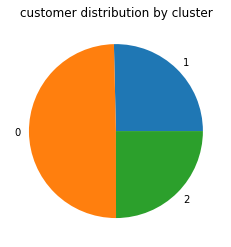

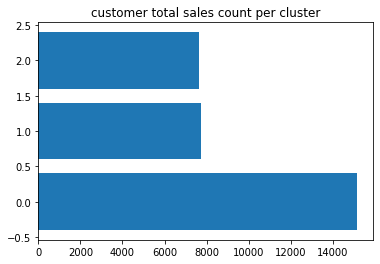

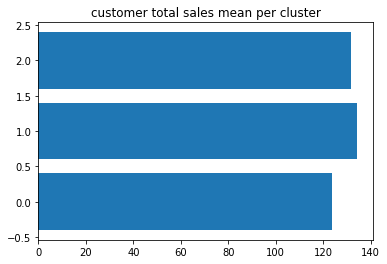

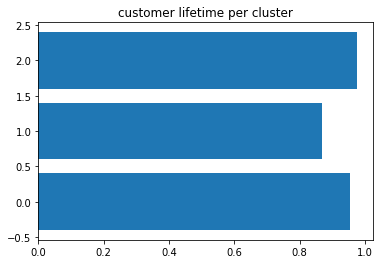

In [68]:
edapx_clustered(grpc0,'customer')

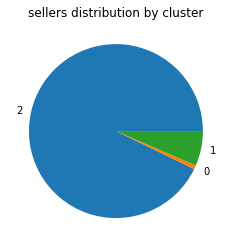

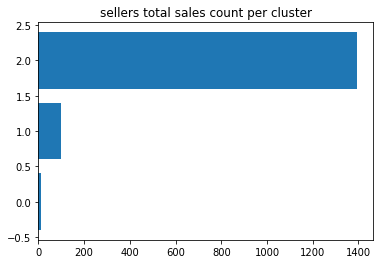

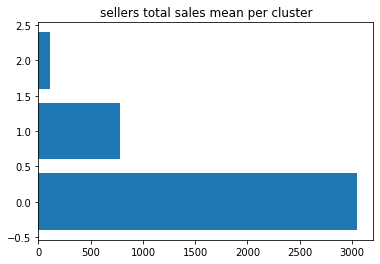

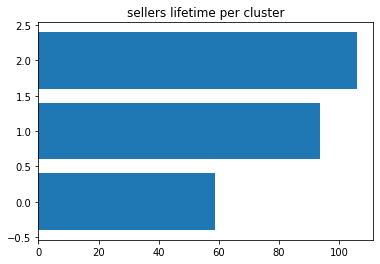

In [69]:
edapx_clustered(grps0,'sellers')

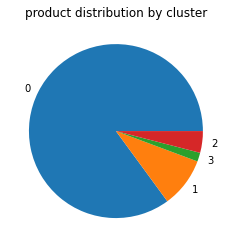

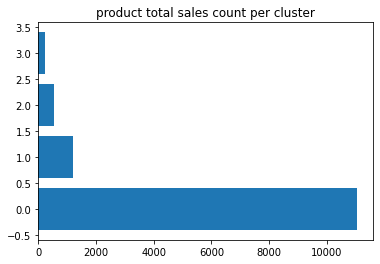

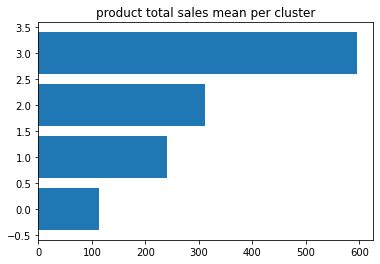

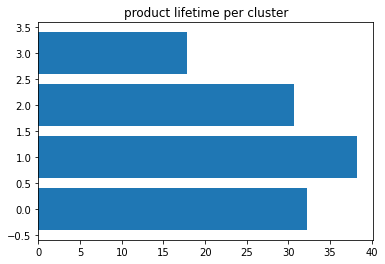

In [70]:
edapx_clustered(grpp0,'product')

more eda per product, cluster: 0


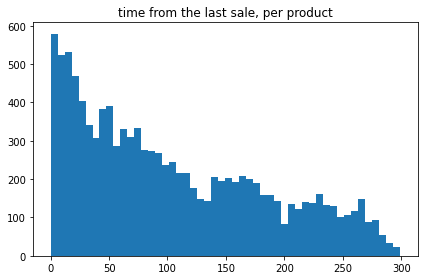

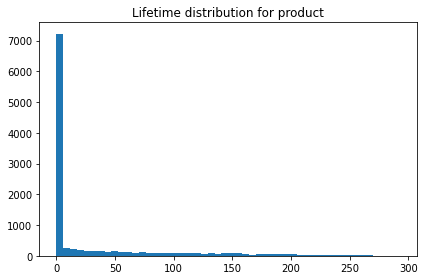

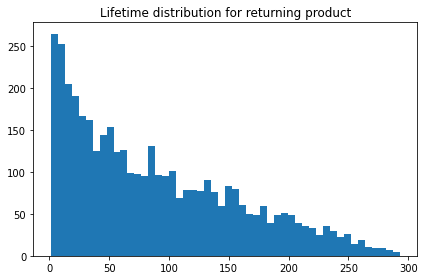

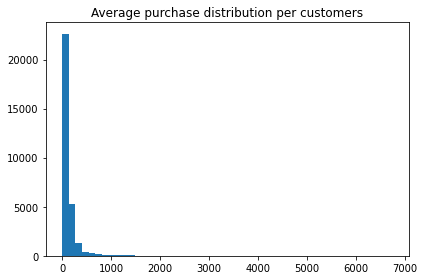

more eda per product, cluster: 1


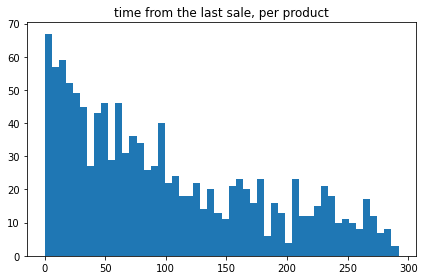

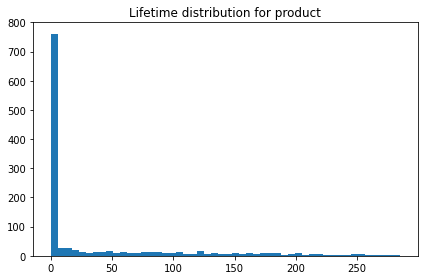

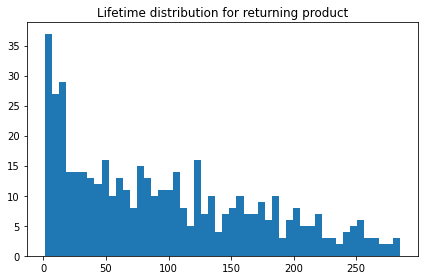

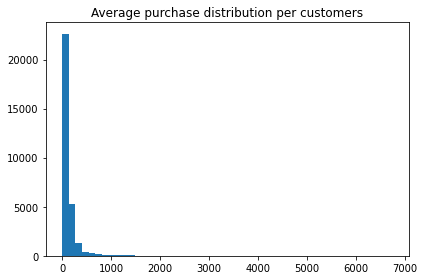

more eda per product, cluster: 3


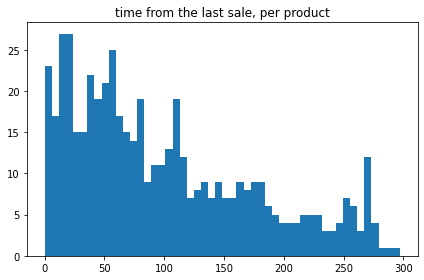

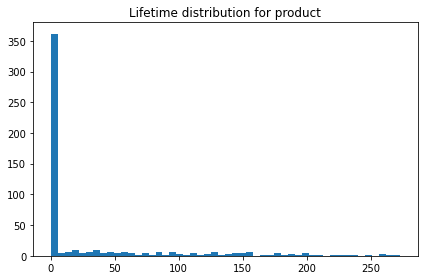

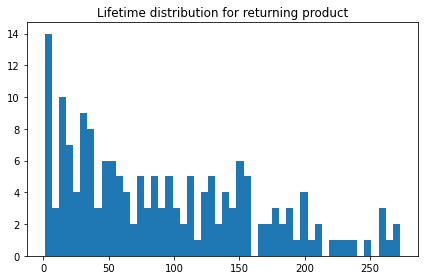

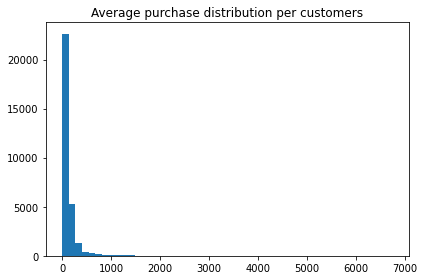

more eda per product, cluster: 2


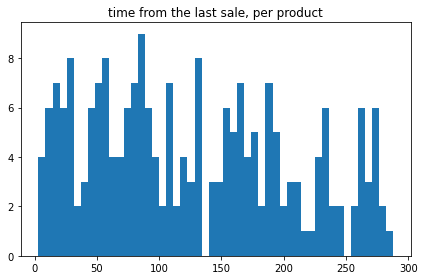

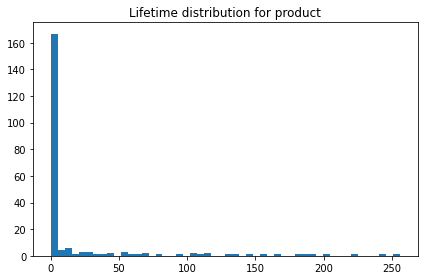

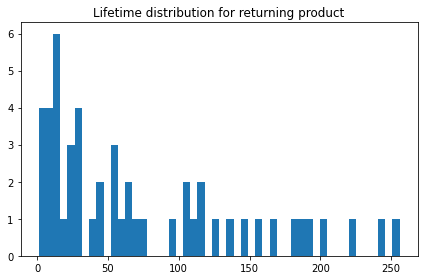

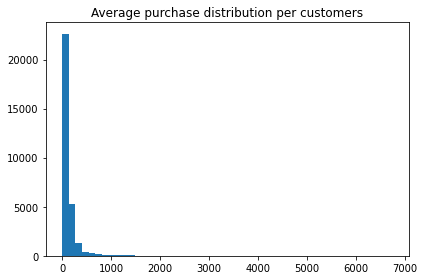

In [71]:
for i in grpp0['cluster'].unique():
    print('more eda per product, cluster: ' + str(i))
    edapx(grpp0[grpp0['cluster'] == i],'product')

more eda per seller, cluster: 2


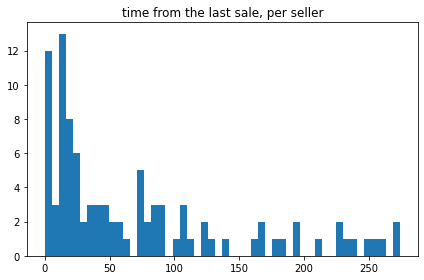

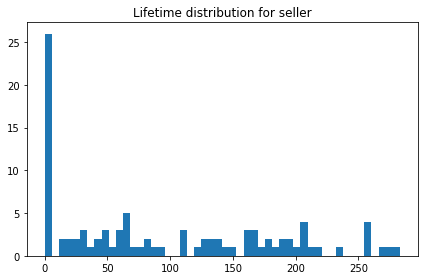

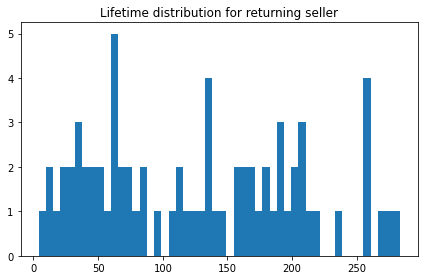

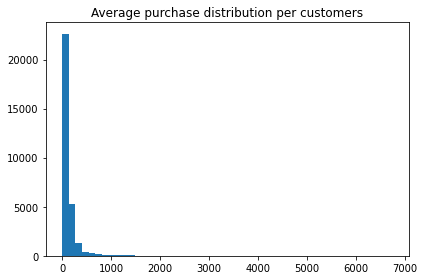

more eda per seller, cluster: 0


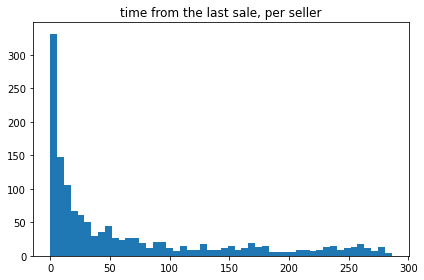

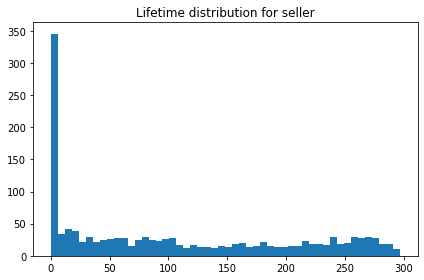

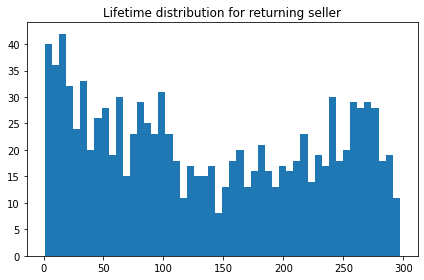

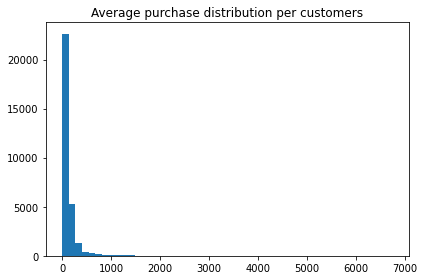

more eda per seller, cluster: 1


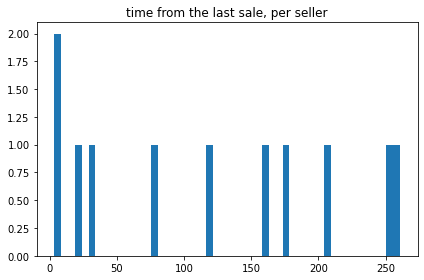

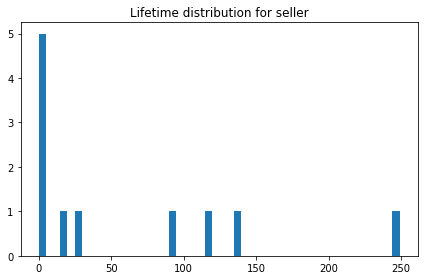

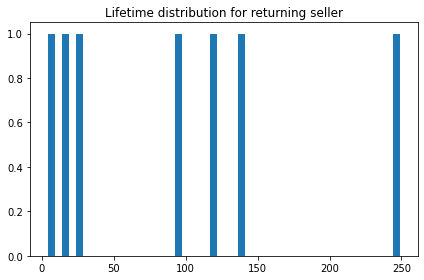

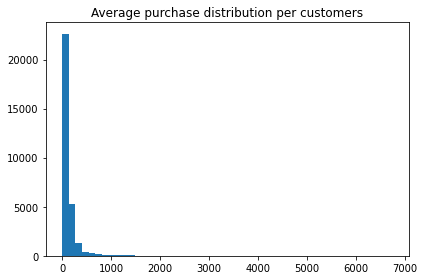

In [72]:
for i in grps0['cluster'].unique():
    print('more eda per seller, cluster: ' + str(i))
    edapx(grps0[grps0['cluster'] == i],'seller')

more eda per customer, cluster: 1


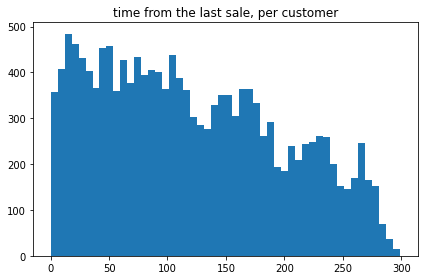

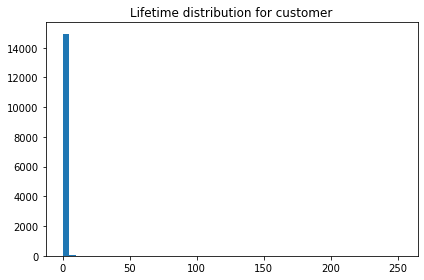

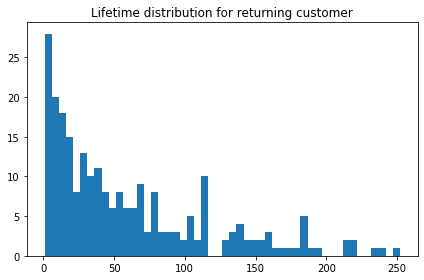

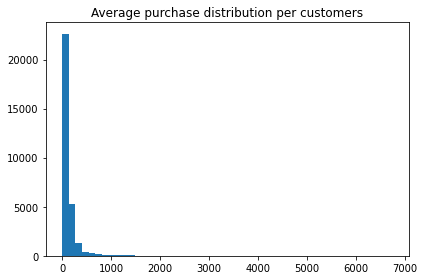

more eda per customer, cluster: 0


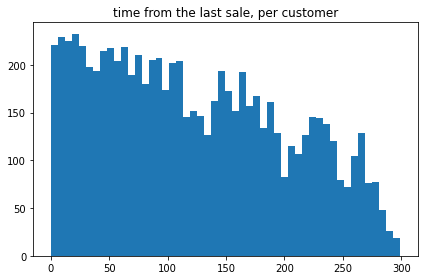

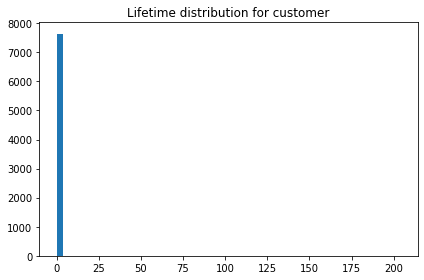

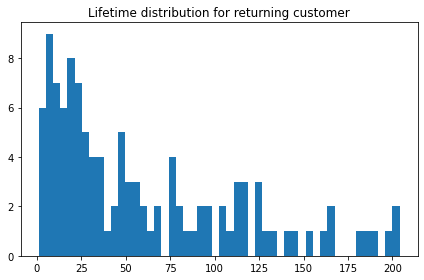

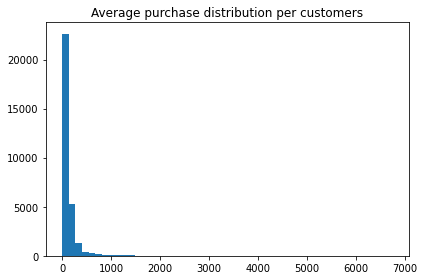

more eda per customer, cluster: 2


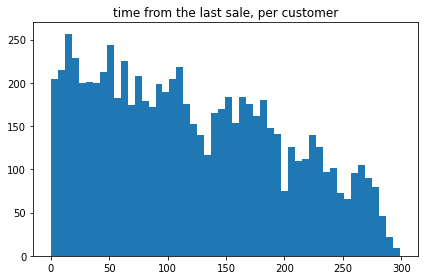

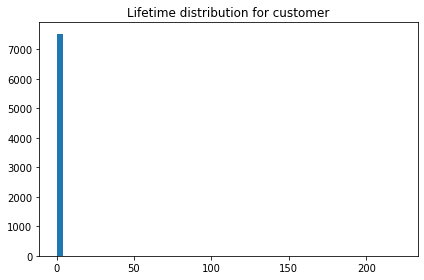

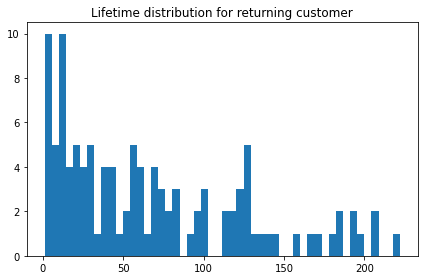

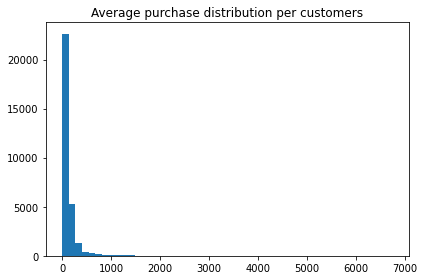

In [73]:
for i in grpc0['cluster'].unique():
    print('more eda per customer, cluster: ' + str(i))
    edapx(grpc0[grpc0['cluster'] == i],'customer')

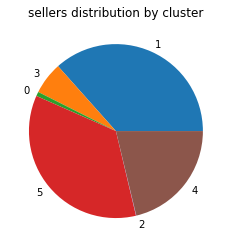

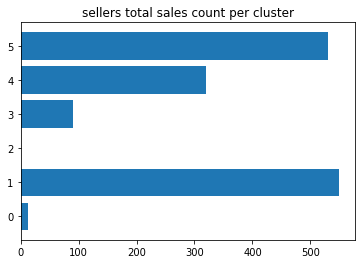

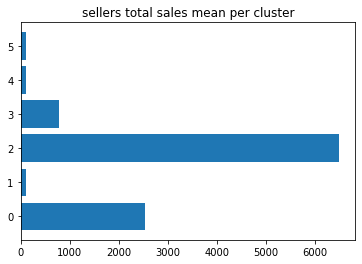

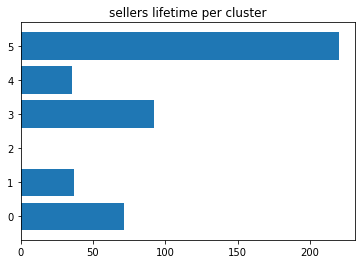

In [74]:
sellers_cluster = KMeans(n_clusters=6,init='k-means++', n_init=20, random_state=random_state,max_iter=400).fit(grps0)
grps0['cluster'] = sellers_cluster.predict(grps0)
edapx_clustered(grps0,'sellers')

more eda per seller, cluster: 1


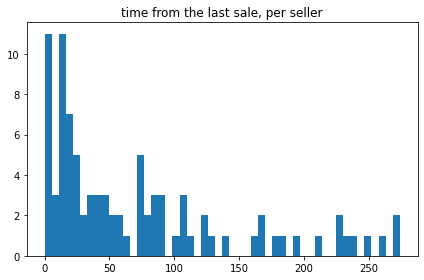

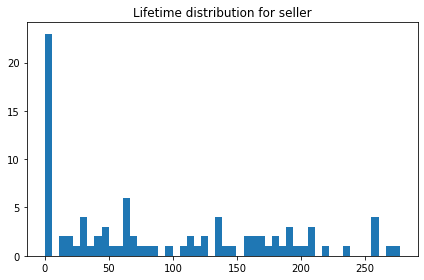

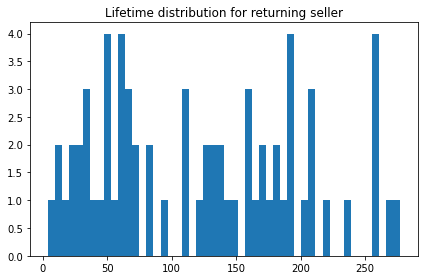

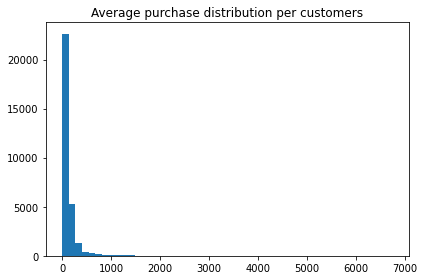

more eda per seller, cluster: 3


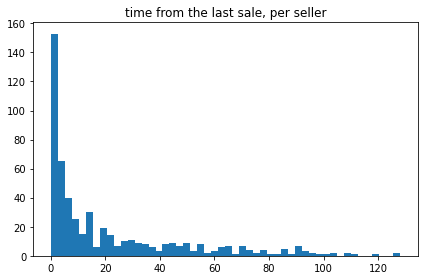

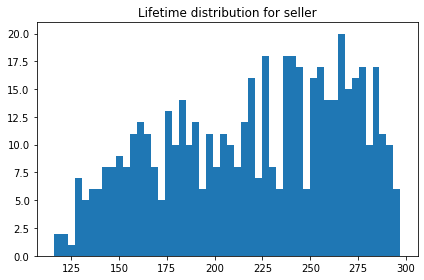

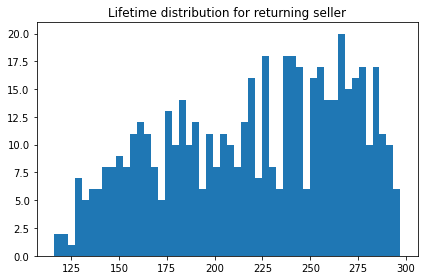

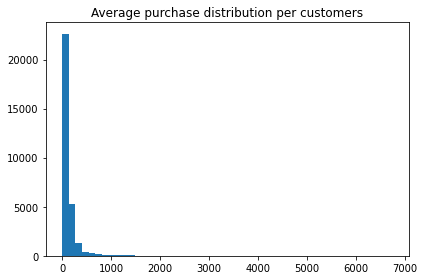

more eda per seller, cluster: 0


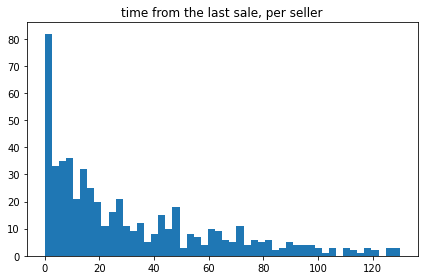

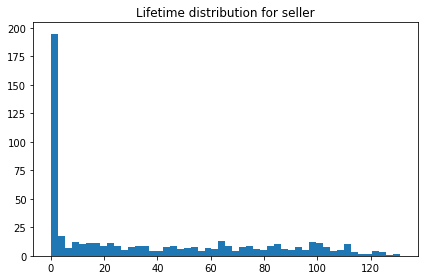

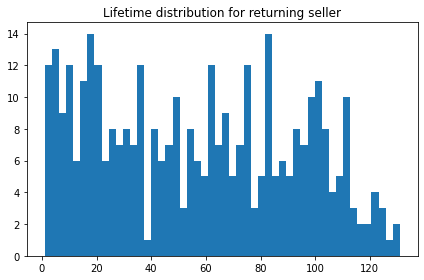

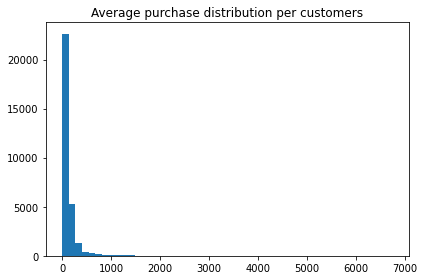

more eda per seller, cluster: 5


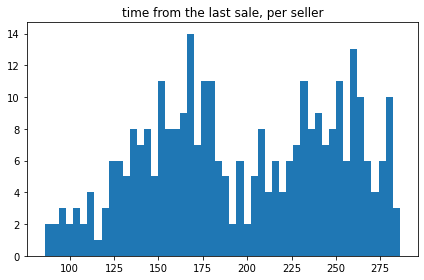

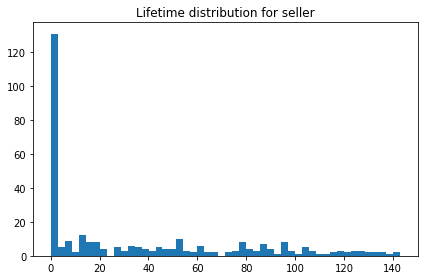

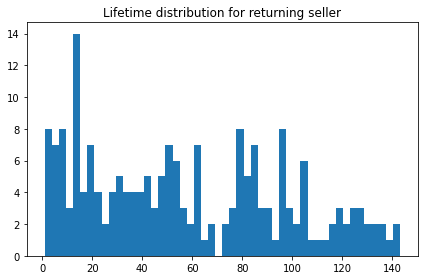

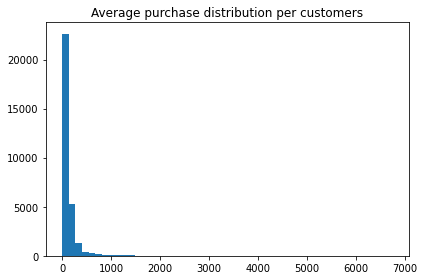

more eda per seller, cluster: 2


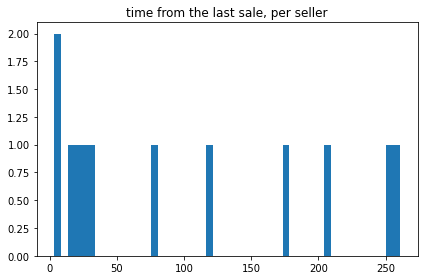

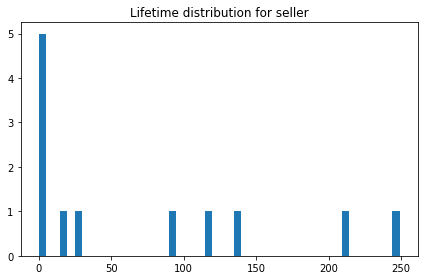

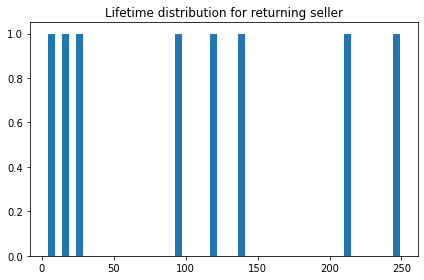

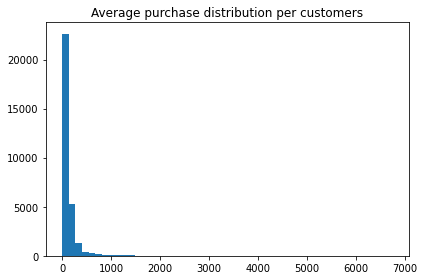

more eda per seller, cluster: 4


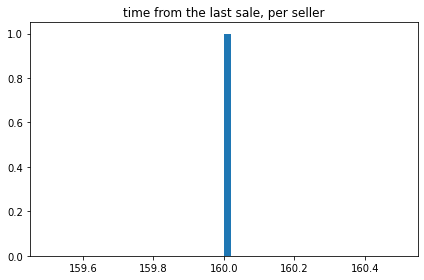

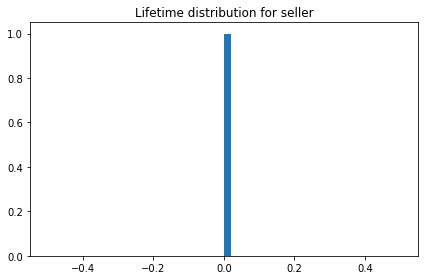

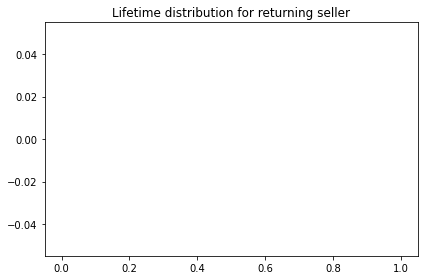

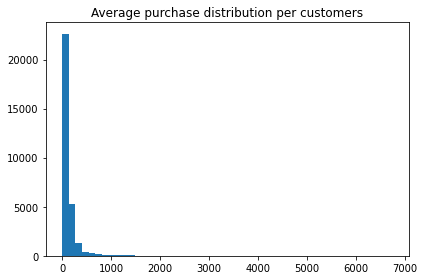

In [75]:
for i in grps0['cluster'].unique():
    print('more eda per seller, cluster: ' + str(i))
    edapx(grps0[grps0['cluster'] == i],'seller')

after examining the distribution and graphs of a 3 clusters split for the sellers, we can see that some features are better split by cluster and some less
so we can afford to take 6 clusters

In [76]:
oips0 = pd.merge(oips0,grps0[['cluster']],left_on='seller_id',right_index=True,how='inner')
oipp0 = pd.merge(oipp0,grpp0[['cluster']],left_on='product_id',right_index=True,how='inner')
oipc0 = pd.merge(oipc0,grpc0[['cluster']],left_on='customer_unique_id',right_index=True,how='inner')

#### now, we're going to add the cluster data for each X, and cluster for each X with the other 2 objects' clusters !

In [77]:
order_items = pd.merge(order_items,grpp0[['cluster']],left_on='product_id',right_index=True,how='left')
order_items.rename(columns={'cluster':'pcluster'}, inplace=True)
order_items = pd.merge(order_items,grps0[['cluster']],left_on='seller_id',right_index=True,how='left')
order_items.rename(columns={'cluster':'scluster'}, inplace=True)
order_items = pd.merge(order_items,grpc0[['cluster']],left_on='customer_unique_id',right_index=True,how='left')
order_items.rename(columns={'cluster':'ccluster'}, inplace=True)

In [78]:
group_vars = "'ccluster':'min','scluster':'min','price':'mean','price':'min','freight_value':'mean','product_category_name':'min','product_name_length':'min','product_photos_qty':'mean','product_weight_g':'mean','product_height_cm':'mean','product_width_cm':'min','product_length_cm':'min'"
oipp0, grpp0 = createOipx(order_items,products,start_date,end_date, merge_on='product_id', group_by=group_vars) ###

#customer_zip_code_prefix	customer_city	customer_state
group_vars = "'ccluster':'min','pcluster':'min','price':'count','price':'sum','price':'mean','freight_value':'mean','seller_state_x':'min'"
oips0, grps0 = createOipx(order_items, sellers, start_date,end_date, merge_on='seller_id',strliaze = 'seller_state_x', group_by=group_vars)

group_vars = "'pcluster':'min','scluster':'min','price':'count','price':'sum','price':'mean','freight_value':'mean','customer_state':'min','customer_city':'min'" # the stares are label ecustomer_idncoded and will always be the same, so minimize will just select the proper label
oipc0, grpc0 = createOipx(order_items, customers, start_date,end_date, merge_on='customer_unique_id',strliaze = 'customer_state', group_by=group_vars)

In [79]:
customer_cluster = KMeans(n_clusters=3,init='k-means++', n_init=20, random_state=random_state,max_iter=400).fit(grpc0)
grpc0['cluster'] = customer_cluster.predict(grpc0)
sellers_cluster = KMeans(n_clusters=3,init='k-means++', n_init=20, random_state=random_state,max_iter=400).fit(grps0)
grps0['cluster'] = sellers_cluster.predict(grps0)
products_cluster = KMeans(n_clusters=4,init='k-means++', n_init=20, random_state=random_state,max_iter=400).fit(grpp0)
grpp0['cluster'] = products_cluster.predict(grpp0)

In [80]:
grpp0.reset_index(inplace=True)
grps0.reset_index(inplace=True)
grpc0.reset_index(inplace=True)

In [81]:
oips0 = pd.merge(oips0,grps0[['seller_id','cluster']],on='seller_id',how='inner')
oipp0 = pd.merge(oipp0,grpp0[['product_id','cluster']],on='product_id',how='inner')
oipc0 = pd.merge(oipc0,grpc0[['customer_unique_id','cluster']],on='customer_unique_id',how='inner')

In [82]:
def TrainTestModel(start_date,end_date,test_start_date,test_end_date,oipxs={'oipc0':oipc0,'oips0':oips0,'oipp0':oipp0},oipxs1={'oipp0':{'grpx':grpp0,'merge_on':'product_id','filter_date':'order_purchase_timestamp','col_to_agg':'price','action':'sum'},'oipc0':{'grpx':grpc0,'merge_on':'customer_unique_id','filter_date':'order_purchase_timestamp','col_to_agg':'price','action':'sum'},'oips0':{'grpx':grps0,'merge_on':'seller_id','filter_date':'order_purchase_timestamp','col_to_agg':'price','action':'sum'}},reg_to_send=pd.DataFrame(),date_filter='order_purchase_timestamp',col_to_agg='price',action='sum'):
    # after all of the parameters in world, there's still a global var reference, meaning - this should have been a part of a class
    sales_sum = order_items[[date_filter,col_to_agg]].copy()
    sales_sum[date_filter] = pd.to_datetime(sales_sum[date_filter]).dt.date
    sales_sum = sales_sum.groupby(date_filter).agg({col_to_agg:action})
    sales_sum.reset_index(inplace=True)
    sales_sum.columns = ['ds','y']
    sales_sum['ds'] = pd.to_datetime(sales_sum['ds']).dt.date
    #train
    sales_sum_train = sales_sum[(sales_sum['ds'] >= start_date.date()) & (sales_sum['ds'] < end_date.date())].copy()
    sales_sum_train['ds'] = pd.to_datetime(sales_sum['ds'])
    #test
    sales_sum_test = sales_sum[(sales_sum['ds'] >= test_start_date.date()) & (sales_sum['ds'] <= test_end_date.date())].copy()
    sales_sum_test['ds'] = pd.to_datetime(sales_sum['ds'])


    final_preds = pd.DataFrame()
    final_preds['ds'] = sales_sum_test['ds']
    final_preds['ds'] = pd.to_datetime(final_preds['ds'])

    final_preds_per_cluster = final_preds.copy()

    #sales sum
    sales_sum_preds = dict

    oipx_preds = pd.DataFrame()
    regressor = pd.DataFrame()

    # the regressor is built for the entire period, to help the prophet predict
    regressor['ds'] = sales_sum['ds']
    regressor['ds'] = pd.to_datetime(regressor['ds'])

    #train = pd.DataFrame()
    #we need this stage so that in the very first iteration, the df will be empty, and the predictor won't break
    #once we have something to work with, right after the 1st loop iteration, we'll populate and improve it
    #reg_to_send = pd.DataFrame()

    tmp = pd.DataFrame()
    print('test shape: ')
    print(sales_sum_test.shape)

    # repeat until 1 result remains

    while len(oipxs) >= 1:

        oipx_preds = pd.DataFrame()
        oipx_preds['ds'] = sales_sum_test['ds']
        oipx_preds['ds'] = pd.to_datetime(oipx_preds['ds'])

        oipx_preds_per_cluster = pd.DataFrame()
        oipx_preds_per_cluster = oipx_preds.copy()
        oipx_preds_per_cluster.set_index('ds', inplace=True)

        #run on all of the clusters, and aggregate
        for oi_name, oipx in oipxs.items():
            print('running on ' + oi_name + ' clusters')
            #filtering the data to the train set to be fit
            train = pd.merge(oipx[[oipxs1[oi_name]['merge_on'],oipxs1[oi_name]['filter_date']]],oipxs1[oi_name]['grpx'][[oipxs1[oi_name]['merge_on'],oipxs1[oi_name]['col_to_agg'],'cluster']],how='inner',on=oipxs1[oi_name]['merge_on'])
            train.drop(oipxs1[oi_name]['merge_on'],inplace=True,axis=1)
            train.columns = [oipxs1[oi_name]['filter_date'],oipxs1[oi_name]['col_to_agg'],'cluster']
            # the actual prediction !!
            tmp = fit_predict(train,filter_date=oipxs1[oi_name]['filter_date'],col_to_agg=oipxs1[oi_name]['col_to_agg'],action=oipxs1[oi_name]['action'],outliers=False, regressor=reg_to_send) #

            oipx_preds = pd.merge(oipx_preds,tmp[['total']],left_on='ds', right_index=True,how='inner')
            oipx_preds.rename(columns={'total':oi_name}, inplace=True)

            # results saving in the proper places
            tmp.drop(['total'],axis=1,inplace=True)
            tmp = tmp.add_suffix('_'+ oi_name + '_per_cluster')
            oipx_preds_per_cluster = pd.merge(oipx_preds_per_cluster,tmp,left_index=True, right_index=True,how='inner')

            train_test_metrices(sales_sum_test['y'], oipx_preds[oi_name], sales_sum_test['ds'])
            

        printGraphs(pd.merge(oipx_preds,sales_sum_test,on='ds',how='inner'),'ds')
        
        # check each aggregation with test
        loss = {}
        preds_list = list(oipx_preds.columns) #.remove('ds')
        preds_list.remove('ds')
        for oipx_pred in preds_list:
            loss[oipx_pred] = sm.r2_score(sales_sum_test['y'],oipx_preds[oipx_pred]) #

        # find the best results based on loss function
        max_value = max(loss.values())  # maximum value
        max_keys = [k for k, v in loss.items() if v == max_value] # getting all keys containing the `maximum`
        max_key = max_keys[0]


        # use the best results as regressor for the rest
        backwarder = oipx_preds[['ds',max_key]]
        backwarder.columns = ['ds','y']
        backwarder = pd.concat([sales_sum_train[['ds','y']],backwarder],ignore_index=True)
        backwarder.columns = ['ds',max_key]
        regressor = pd.merge(regressor,backwarder,on='ds',how='left')
        #we need this stage so that in the very first iteration, the df will be empty, and the predictor won't break
        #once we have something to work with, right after the 1st loop iteration, we'll populate and improve it
        
        #kept in comment until the regressor is fixed
        #reg_to_send = regressor
        
        
        incol = '_' + max_key + '_per_cluster'
        final_cols = [col for col in oipx_preds_per_cluster.columns if incol in col]
        final_preds_per_cluster = pd.merge(final_preds_per_cluster,oipx_preds_per_cluster[final_cols],left_on='ds', right_index=True, how='inner')
        final_preds = pd.merge(final_preds,oipx_preds[['ds',max_key]],on='ds', how='inner')

        # remove the best results function from the network
        #oipxs0.remove(max_key)
        del oipxs[max_key]
        print(oipxs.keys())

    # average it all
    final_preds.set_index('ds', inplace=True)
    final_preds['mean'] = final_preds.mean(axis=1)
    
    return final_preds, final_preds_per_cluster, reg_to_send

test shape: 
(242, 2)
running on oipc0 clusters
prediction vs test
mean absolute error:  10902.17
root mean squared error:  15038.34
median absolute error:  9509.21
explained variance score:  -0.15
r2 score:  -0.58


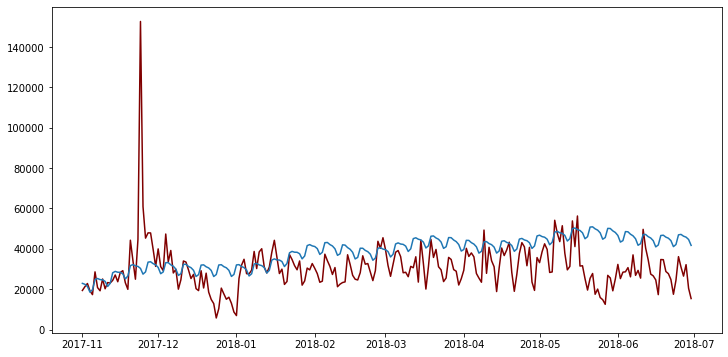

running on oips0 clusters
prediction vs test
mean absolute error:  9384.0
root mean squared error:  13803.56
median absolute error:  7983.85
explained variance score:  -0.27
r2 score:  -0.33


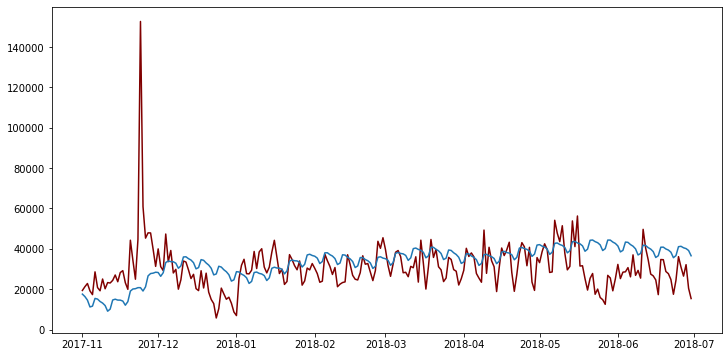

running on oipp0 clusters
prediction vs test
mean absolute error:  8655.21
root mean squared error:  13104.87
median absolute error:  7059.69
explained variance score:  -0.1
r2 score:  -0.2


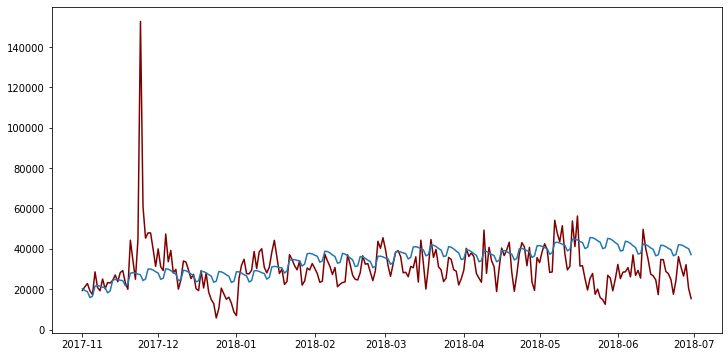

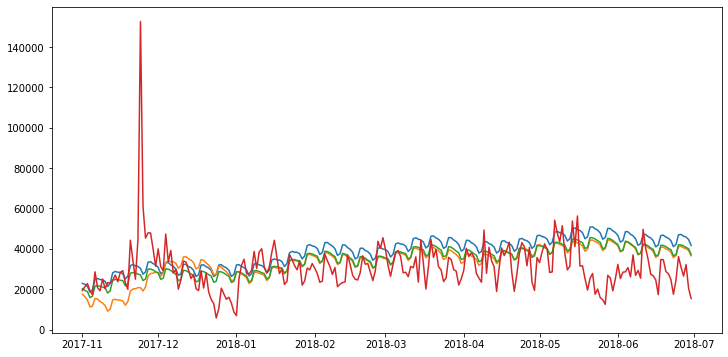

dict_keys(['oipc0', 'oips0'])
running on oipc0 clusters
prediction vs test
mean absolute error:  10902.17
root mean squared error:  15038.34
median absolute error:  9509.21
explained variance score:  -0.15
r2 score:  -0.58


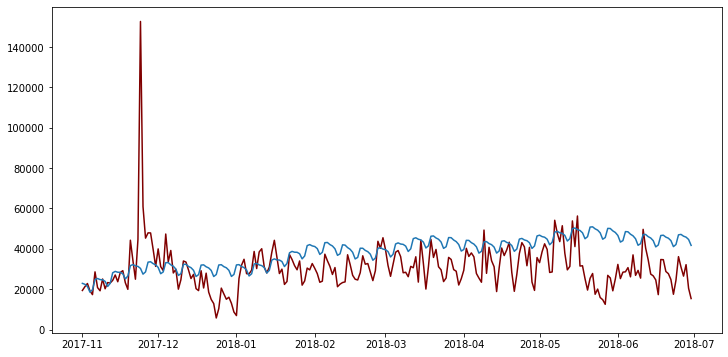

running on oips0 clusters
prediction vs test
mean absolute error:  9384.0
root mean squared error:  13803.56
median absolute error:  7983.85
explained variance score:  -0.27
r2 score:  -0.33


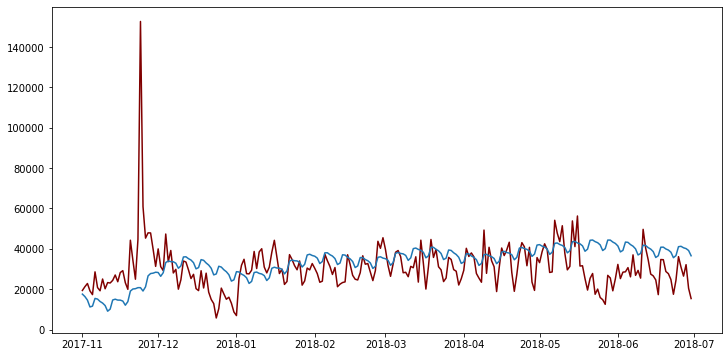

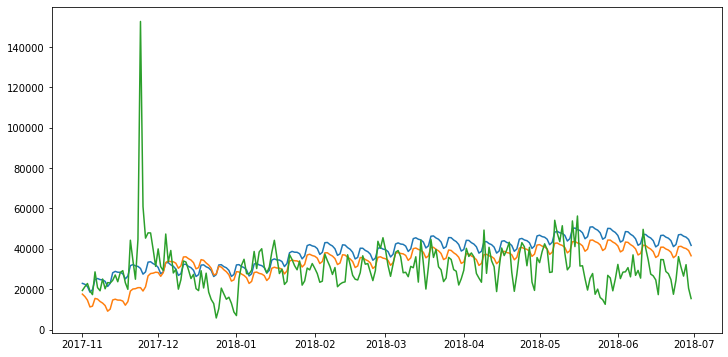

dict_keys(['oipc0'])
running on oipc0 clusters
prediction vs test
mean absolute error:  10902.17
root mean squared error:  15038.34
median absolute error:  9509.21
explained variance score:  -0.15
r2 score:  -0.58


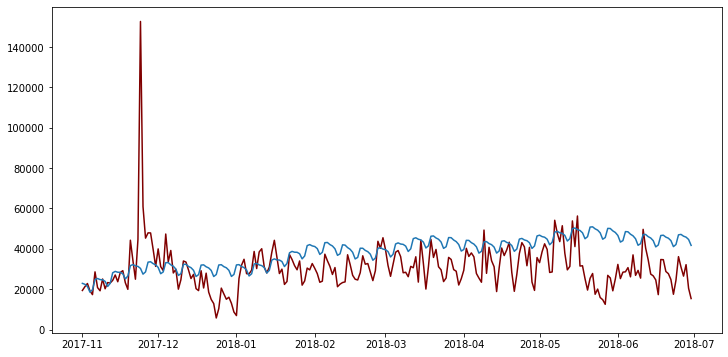

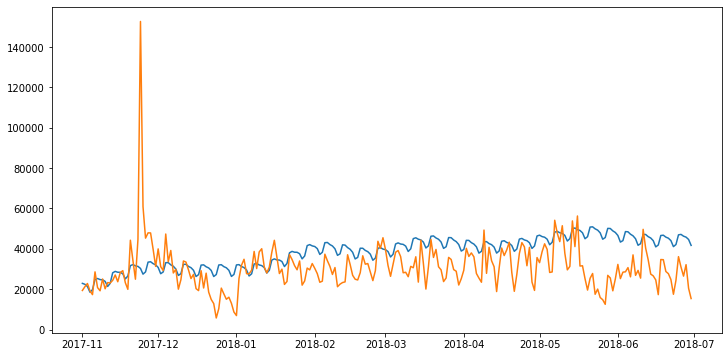

dict_keys([])


In [83]:
oipxs = {
    'oipc0':oipc0,
    'oips0':oips0,
    'oipp0':oipp0
}

oipxs1 = {
        'oipp0':{'grpx':grpp0,'merge_on':'product_id','filter_date':'order_purchase_timestamp','col_to_agg':'price','action':'sum'},
        'oipc0':{'grpx':grpc0,'merge_on':'customer_unique_id','filter_date':'order_purchase_timestamp','col_to_agg':'price','action':'sum'},
        'oips0':{'grpx':grps0,'merge_on':'seller_id','filter_date':'order_purchase_timestamp','col_to_agg':'price','action':'sum'}
         }
    
sum_final_preds, sum_final_preds_per_cluster, sum_reg_to_send = TrainTestModel(start_date,end_date,test_start_date,test_end_date,oipxs=oipxs,oipxs1=oipxs1,date_filter='order_purchase_timestamp',col_to_agg='price',action='sum')

test shape: 
(242, 2)
running on oipc0 clusters
prediction vs test
mean absolute error:  89.35
root mean squared error:  130.05
median absolute error:  72.47
explained variance score:  -0.34
r2 score:  -0.59


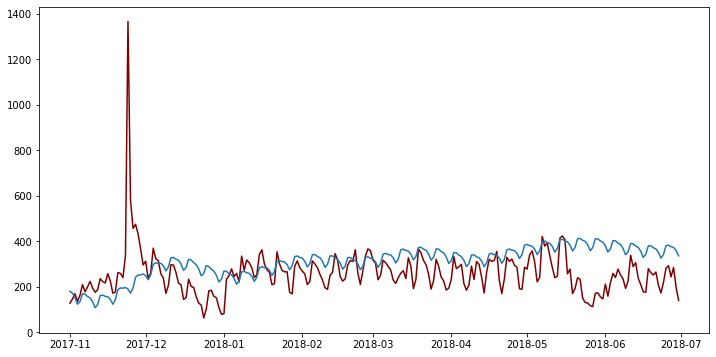

running on oips0 clusters
prediction vs test
mean absolute error:  75.04
root mean squared error:  118.02
median absolute error:  61.63
explained variance score:  -0.22
r2 score:  -0.31


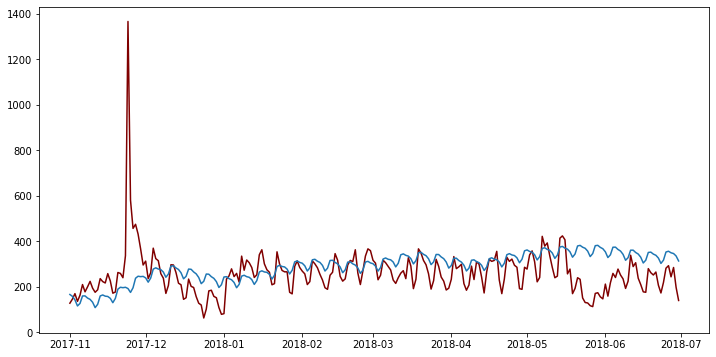

running on oipp0 clusters
prediction vs test
mean absolute error:  77.78
root mean squared error:  121.06
median absolute error:  67.79
explained variance score:  -0.31
r2 score:  -0.38


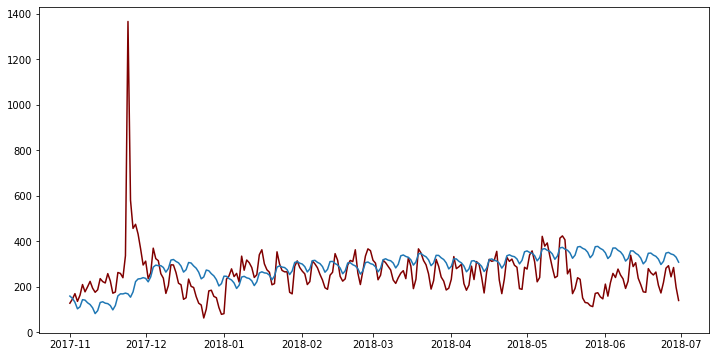

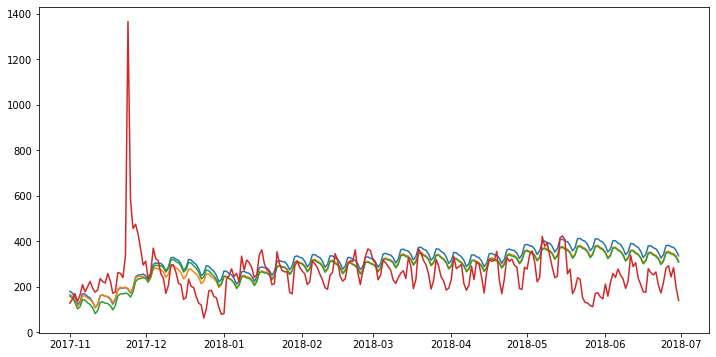

dict_keys(['oipc0', 'oipp0'])
running on oipc0 clusters
prediction vs test
mean absolute error:  89.35
root mean squared error:  130.05
median absolute error:  72.47
explained variance score:  -0.34
r2 score:  -0.59


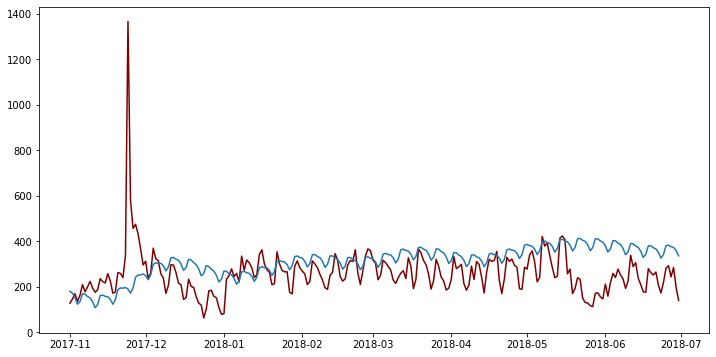

running on oipp0 clusters
prediction vs test
mean absolute error:  77.78
root mean squared error:  121.06
median absolute error:  67.79
explained variance score:  -0.31
r2 score:  -0.38


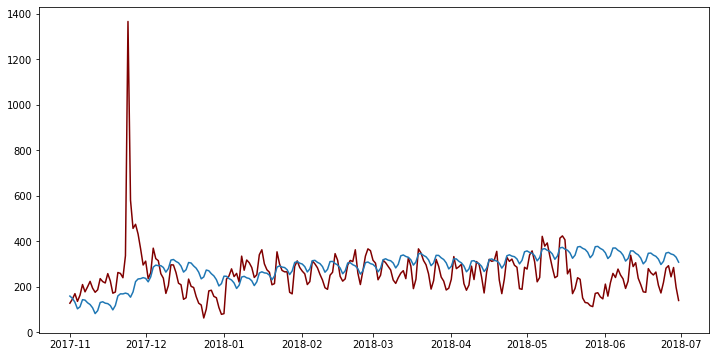

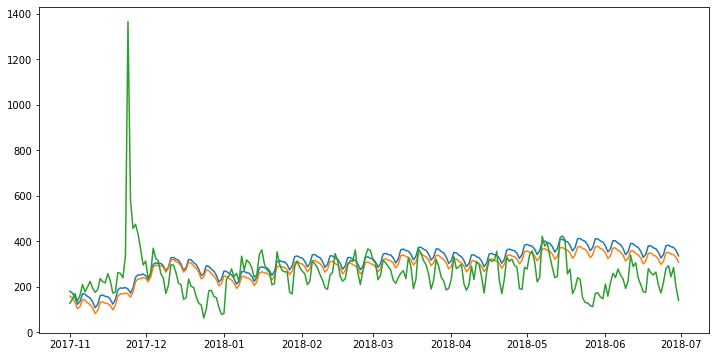

dict_keys(['oipc0'])
running on oipc0 clusters
prediction vs test
mean absolute error:  89.35
root mean squared error:  130.05
median absolute error:  72.47
explained variance score:  -0.34
r2 score:  -0.59


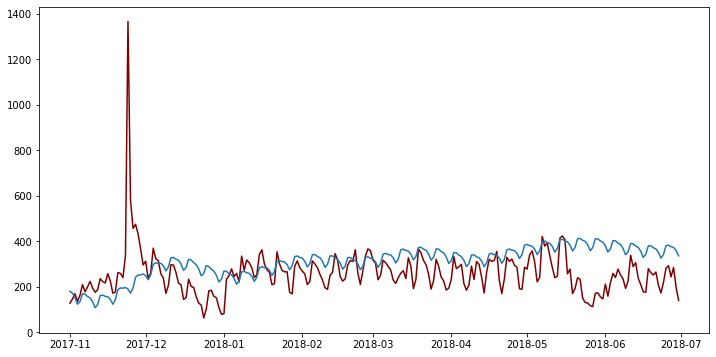

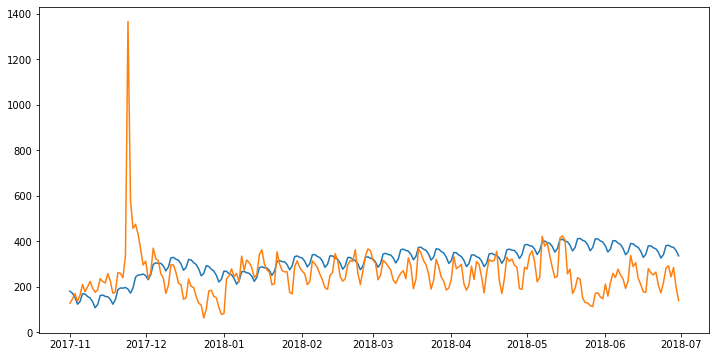

dict_keys([])


In [84]:
oipxs = {
    'oipc0':oipc0,
    'oips0':oips0,
    'oipp0':oipp0
}

oipxs2 = {
        'oipp0':{'grpx':grpp0,'merge_on':'product_id','filter_date':'order_purchase_timestamp','col_to_agg':'price','action':'count'},
        'oipc0':{'grpx':grpc0,'merge_on':'customer_unique_id','filter_date':'order_purchase_timestamp','col_to_agg':'price','action':'count'},
        'oips0':{'grpx':grps0,'merge_on':'seller_id','filter_date':'order_purchase_timestamp','col_to_agg':'price','action':'count'}
         }
cnt_final_preds, cnt_final_preds_per_cluster, cnt_reg_to_send = TrainTestModel(start_date,end_date,test_start_date,test_end_date,oipxs=oipxs,oipxs1=oipxs2,date_filter='order_purchase_timestamp',col_to_agg='price',action='count')

In [85]:
cnt_final_preds.head()
cnt_final_preds_per_cluster.head()
cnt_reg_to_send.head()

""


Setting the data to be monthly, we'll check it's scoring, and start building the final data frames

### unique X prediction

In [86]:
unique_sellers_pred = pd.DataFrame()
unique_products_pred = pd.DataFrame()
unique_customers_pred = pd.DataFrame()

uniques = {
 'sellers': {
 'unique_x_per_cluster':countUniqueXPerCluster(oips0,'cluster','seller_id','order_purchase_timestamp'),#playing around with annoymous DFs...
 'unique_x': unique_sellers,
 'pred':unique_sellers_pred,
 'idx':'seller_id'
 },
  'products': {
 'unique_x_per_cluster':countUniqueXPerCluster(oipp0,'cluster','product_id','order_purchase_timestamp'),
 'unique_x': unique_products,
 'pred':unique_products_pred,
 'idx':'product_id'
 },
  'customers': {
  'unique_x_per_cluster':countUniqueXPerCluster(oipc0,'cluster','customer_unique_id','order_purchase_timestamp'),
  'unique_x': unique_customers,
  'pred':unique_customers_pred,
  'idx':'customer_unique_id'
 }
}

sellers
prediction vs test
mean absolute error:  49.47
root mean squared error:  60.78
median absolute error:  44.66
explained variance score:  -1.43
r2 score:  -1.87


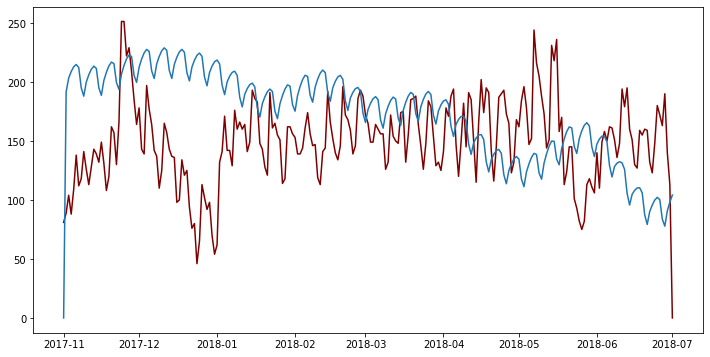

products
prediction vs test
mean absolute error:  66.16
root mean squared error:  89.83
median absolute error:  57.07
explained variance score:  -0.49
r2 score:  -0.55


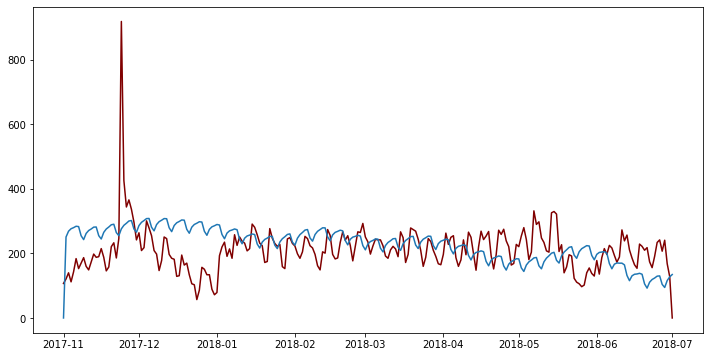

customers
prediction vs test
mean absolute error:  73.6
root mean squared error:  103.3
median absolute error:  65.13
explained variance score:  -0.37
r2 score:  -0.4


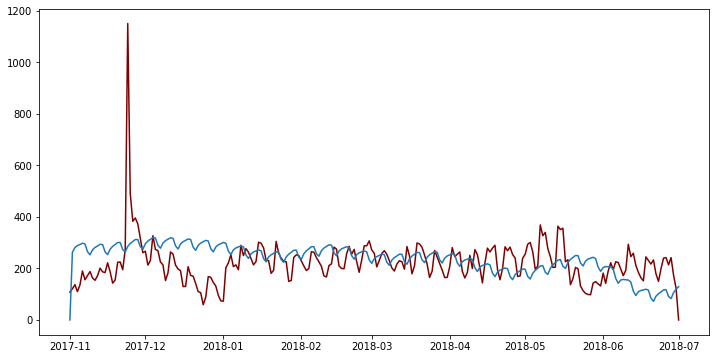

In [87]:
for unique_type, unique_ref in uniques.items():
    unique_ref['pred'] = fit_predict(unique_ref['unique_x_per_cluster'],filter_date='date',col_to_agg='x_count',action='sum',outliers=False,regressor=pd.DataFrame())
    unique_ref['pred'].reset_index(inplace=True)
    
    pred = unique_ref['pred'][(unique_ref['pred']['ds'].dt.date >= test_start_date.date()) & (unique_ref['pred']['ds'].dt.date <= test_end_date.date())]
    test = unique_ref['unique_x'][(unique_ref['unique_x']['date'].dt.date >= test_start_date.date()) & (unique_ref['unique_x']['date'].dt.date <= test_end_date.date())]
    print(unique_type)
    train_test_metrices(test['x_count'],pred['total'], test['date'])

unique_customers_pred = uniques['customers']['pred']
unique_products_pred = uniques['products']['pred']
unique_sellers_pred = uniques['sellers']['pred']

### Final quality control and summarizing the data

In [88]:
sum_final_preds.reset_index(inplace=True)
cnt_final_preds.reset_index(inplace=True)

In [89]:
#nique_sellers_pred
#nique_products_pred
#nique_customers_pred

In [90]:
#cnt_final_preds.head()
#cnt_final_preds_per_cluster.head()

In [91]:
#sum_final_predssum_final_preds
#sum_final_preds_per_cluster

In [92]:
sum_final_preds.head()

,ds,oipp0,oips0,oipc0,mean
0,2017-11-01,20241.676958,17581.583165,22901.963914,20241.741346
1,2017-11-02,19381.527888,16354.279202,22435.440529,19390.415873
2,2017-11-03,18784.642048,14606.774196,21349.872461,18247.096235
3,2017-11-04,15854.910048,11220.950122,18532.677751,15202.845974
4,2017-11-05,16587.154104,11625.491869,19772.989675,15995.211883


In [93]:
grped_oiCust_predicted = pd.DataFrame(index=grped_oiCust.index)

In [94]:
YM = yearMonth(cnt_final_preds,'ds','sum')
grped_oiCust_predicted = pd.merge(grped_oiCust_predicted,YM[['mean']],left_index=True, right_index=True,how='left')
grped_oiCust_predicted.rename(columns={'mean':'SalesCount'}, inplace=True)

YM = yearMonth(sum_final_preds,'ds','sum')
grped_oiCust_predicted = pd.merge(grped_oiCust_predicted,YM[['mean']],left_index=True, right_index=True,how='left')
grped_oiCust_predicted.rename(columns={'mean':'SalesSum'}, inplace=True)

YM = yearMonth(unique_customers_pred,'ds','mean')
YM['total']
grped_oiCust_predicted = pd.merge(grped_oiCust_predicted,YM[['total']],left_index=True, right_index=True,how='left')
grped_oiCust_predicted.rename(columns={'total':'CustomersCount'}, inplace=True)

YM = yearMonth(unique_sellers_pred,'ds','mean')
grped_oiCust_predicted = pd.merge(grped_oiCust_predicted,YM[['total']],left_index=True, right_index=True,how='left')
grped_oiCust_predicted.rename(columns={'total':'SellersCount'}, inplace=True)

YM = yearMonth(unique_products_pred,'ds','mean')
grped_oiCust_predicted = pd.merge(grped_oiCust_predicted,YM[['total']],left_index=True, right_index=True,how='left')
grped_oiCust_predicted.rename(columns={'total':'ProductsCount'}, inplace=True)


In [95]:
grped_oiCust_predicted['MeanSale'] = round(grped_oiCust_predicted['SalesSum'] / grped_oiCust_predicted['SalesCount'],2)
grped_oiCust_predicted['SalesPerSeller'] = round(grped_oiCust_predicted['SalesSum'] / grped_oiCust_predicted['SellersCount'],2)
grped_oiCust_predicted['SalesPerCustomer'] = round(grped_oiCust_predicted['SalesSum'] / grped_oiCust_predicted['CustomersCount'],2)
grped_oiCust_predicted['PurchasesPerCustomer'] = round(grped_oiCust_predicted['SalesCount'] / grped_oiCust_predicted['CustomersCount'],2)

In [96]:
test_start_year_month = test_start_date.year * 100 + test_start_date.month #dt.datetime(2017, 1, 1)
test_end_year_month = test_end_date.year * 100 + test_end_date.month

In [97]:
grped_oiCust_predicted[((grped_oiCust_predicted.index >= int(test_start_year_month)) & (grped_oiCust_predicted.index < int(test_end_year_month)))]

,SalesCount,SalesSum,CustomersCount,SellersCount,ProductsCount,MeanSale,SalesPerSeller,SalesPerCustomer,PurchasesPerCustomer
yearmonth,,,,,,,,,
201711,4862.301511,6.768383e+05,129.924163,111.918705,142.998849,139.20,6047.59,5209.49,37.42
201712,8324.719163,9.089343e+05,213.347310,142.267305,190.172049,109.18,6388.92,4260.35,39.02
201801,8073.276032,9.728430e+05,206.936297,148.560397,197.219072,120.50,6548.47,4701.17,39.01
201802,8386.905278,1.019454e+06,243.600861,179.391816,234.716080,121.55,5682.84,4184.94,34.43
201803,10018.661689,1.217359e+06,263.203234,192.450331,252.855522,121.51,6325.57,4625.17,38.06
201804,9524.766474,1.165055e+06,259.990859,191.644466,250.148206,122.32,6079.25,4481.14,36.64
201805,11323.145429,1.358955e+06,298.435827,216.833597,289.140552,120.02,6267.27,4553.59,37.94
201806,10433.714799,1.249812e+06,284.705110,206.756051,274.129589,119.79,6044.86,4389.85,36.65


In [98]:
grped_oiCust[((grped_oiCust.index >= int(test_start_year_month)) & (grped_oiCust.index < int(test_end_year_month)))]

,SalesCount,SalesSum,CustomersCount,SellersCount,ProductsCount,MeanSale,SalesPerSeller,SalesPerCustomer,PurchasesPerCustomer
yearmonth,,,,,,,,,
201711,9385,1081776.68,245.866667,150.933333,230.000000,115.27,7167.25,4399.85,38.17
201712,6816,794650.06,179.838710,119.935484,171.967742,116.59,6625.65,4418.68,37.90
201801,8839,1017450.44,230.580645,150.709677,219.967742,115.11,6751.06,4412.56,38.33
201802,8486,917563.48,234.535714,155.464286,221.678571,108.13,5902.09,3912.25,36.18
201803,8845,1037128.80,229.741935,155.967742,219.354839,117.26,6649.64,4514.32,38.50
201804,8529,1054438.98,230.266667,163.933333,221.466667,123.63,6432.12,4579.21,37.04
201805,8494,1056820.11,220.354839,153.580645,206.322581,124.42,6881.21,4795.99,38.55
201806,7515,910738.88,204.766667,153.166667,200.533333,121.19,5946.06,4447.69,36.70


In [99]:
pred_grouped = round(grped_oiCust_predicted[((grped_oiCust_predicted.index >= int(test_start_year_month)) & (grped_oiCust_predicted.index < int(test_end_year_month)))],2)
test_grouped = round(grped_oiCust[((grped_oiCust.index >= int(test_start_year_month)) & (grped_oiCust.index < int(test_end_year_month)))],2)

In [100]:
pred_grouped.head(8)

,SalesCount,SalesSum,CustomersCount,SellersCount,ProductsCount,MeanSale,SalesPerSeller,SalesPerCustomer,PurchasesPerCustomer
yearmonth,,,,,,,,,
201711,4862.30,676838.27,129.92,111.92,143.00,139.20,6047.59,5209.49,37.42
201712,8324.72,908934.27,213.35,142.27,190.17,109.18,6388.92,4260.35,39.02
201801,8073.28,972843.05,206.94,148.56,197.22,120.50,6548.47,4701.17,39.01
201802,8386.91,1019454.11,243.60,179.39,234.72,121.55,5682.84,4184.94,34.43
201803,10018.66,1217358.67,263.20,192.45,252.86,121.51,6325.57,4625.17,38.06
201804,9524.77,1165054.82,259.99,191.64,250.15,122.32,6079.25,4481.14,36.64
201805,11323.15,1358955.26,298.44,216.83,289.14,120.02,6267.27,4553.59,37.94
201806,10433.71,1249812.31,284.71,206.76,274.13,119.79,6044.86,4389.85,36.65


In [101]:
test_grouped.head(8)

,SalesCount,SalesSum,CustomersCount,SellersCount,ProductsCount,MeanSale,SalesPerSeller,SalesPerCustomer,PurchasesPerCustomer
yearmonth,,,,,,,,,
201711,9385,1081776.68,245.87,150.93,230.00,115.27,7167.25,4399.85,38.17
201712,6816,794650.06,179.84,119.94,171.97,116.59,6625.65,4418.68,37.90
201801,8839,1017450.44,230.58,150.71,219.97,115.11,6751.06,4412.56,38.33
201802,8486,917563.48,234.54,155.46,221.68,108.13,5902.09,3912.25,36.18
201803,8845,1037128.80,229.74,155.97,219.35,117.26,6649.64,4514.32,38.50
201804,8529,1054438.98,230.27,163.93,221.47,123.63,6432.12,4579.21,37.04
201805,8494,1056820.11,220.35,153.58,206.32,124.42,6881.21,4795.99,38.55
201806,7515,910738.88,204.77,153.17,200.53,121.19,5946.06,4447.69,36.70


metrices for: SalesCount
prediction vs test
mean absolute error:  1851.69
root mean squared error:  2297.26
median absolute error:  1341.19
explained variance score:  -7.59
r2 score:  -8.03


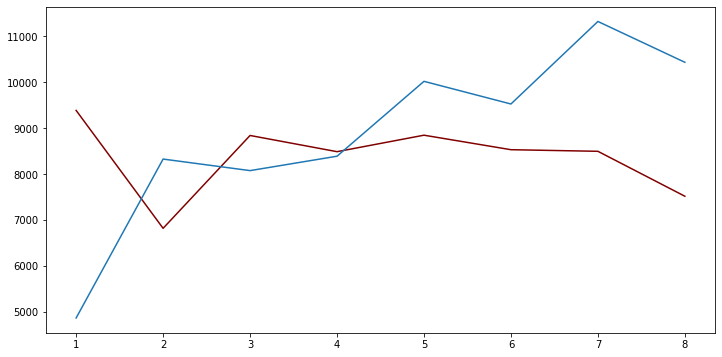

metrices for: SalesSum
prediction vs test
mean absolute error:  199721.87
root mean squared error:  234622.74
median absolute error:  147257.04
explained variance score:  -4.47
r2 score:  -5.35


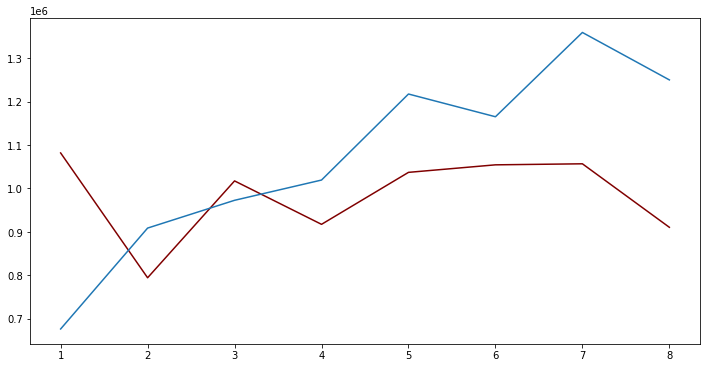

metrices for: CustomersCount
prediction vs test
mean absolute error:  50.42
root mean squared error:  60.93
median absolute error:  33.48
explained variance score:  -8.24
r2 score:  -8.88


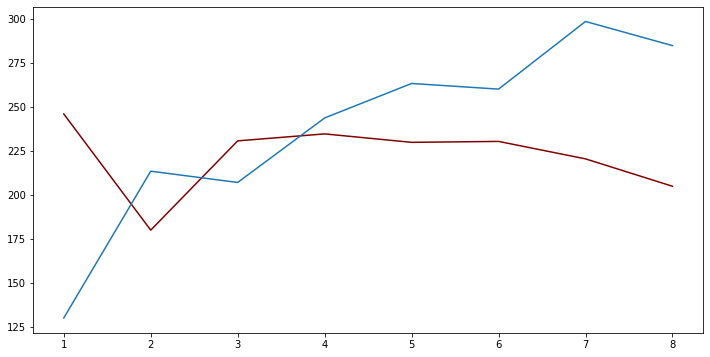

metrices for: SellersCount
prediction vs test
mean absolute error:  33.56
root mean squared error:  38.03
median absolute error:  32.09
explained variance score:  -5.1
r2 score:  -8.76


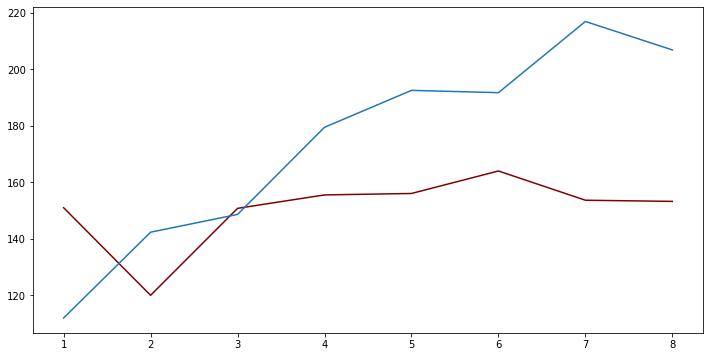

metrices for: ProductsCount
prediction vs test
mean absolute error:  44.95
root mean squared error:  53.4
median absolute error:  31.1
explained variance score:  -7.52
r2 score:  -8.55


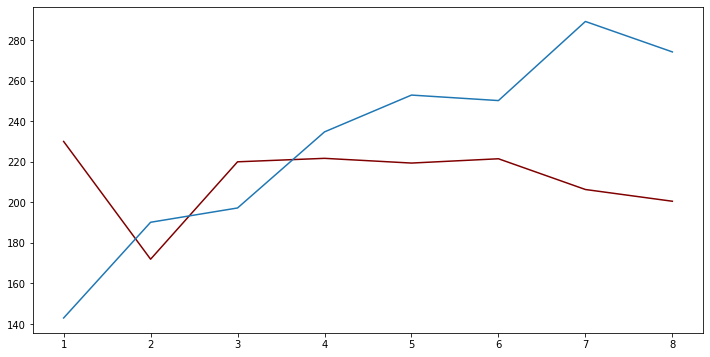

metrices for: MeanSale
prediction vs test
mean absolute error:  7.69
root mean squared error:  10.47
median absolute error:  4.9
explained variance score:  -2.77
r2 score:  -3.43


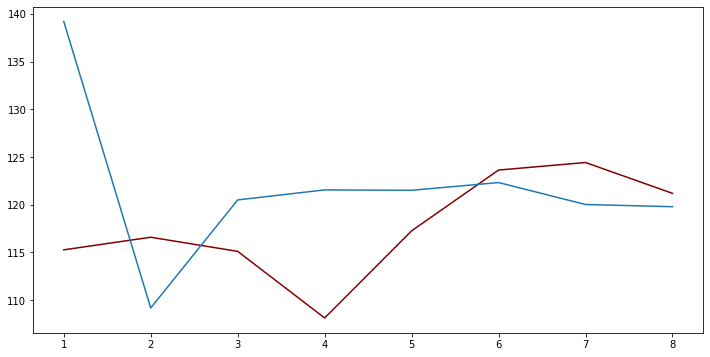

metrices for: SalesPerSeller
prediction vs test
mean absolute error:  395.99
root mean squared error:  501.87
median absolute error:  280.4
explained variance score:  0.32
r2 score:  -0.5


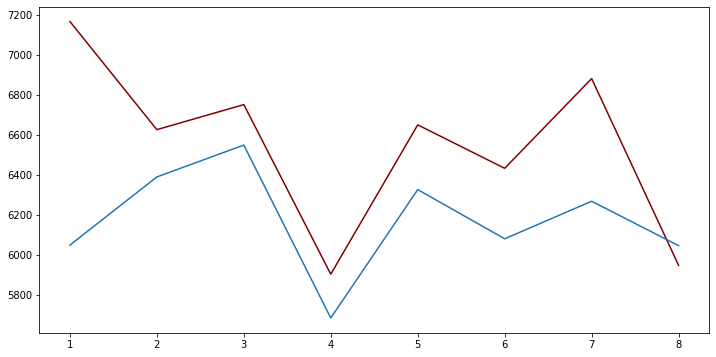

metrices for: SalesPerCustomer
prediction vs test
mean absolute error:  254.8
root mean squared error:  339.53
median absolute error:  200.36
explained variance score:  -0.88
r2 score:  -1.13


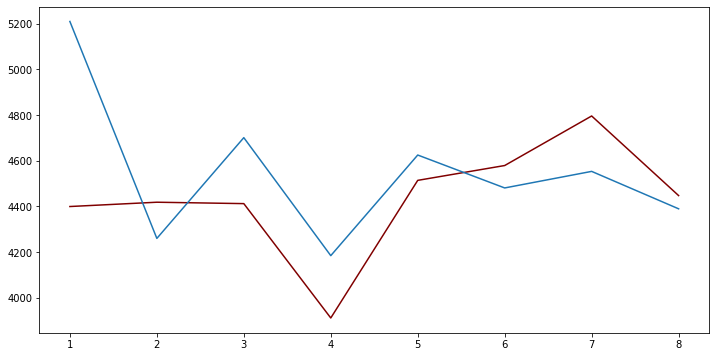

metrices for: PurchasesPerCustomer
prediction vs test
mean absolute error:  0.73
root mean squared error:  0.87
median absolute error:  0.64
explained variance score:  0.05
r2 score:  -0.05


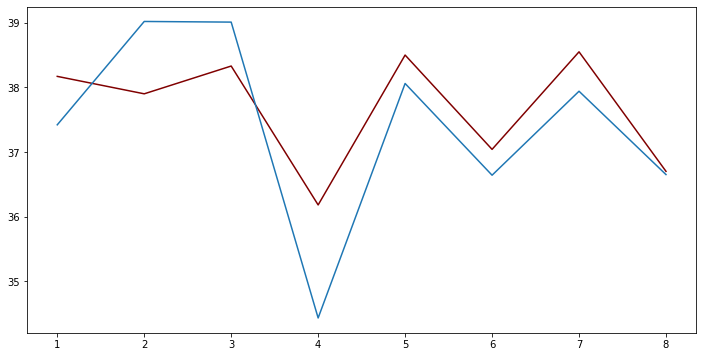

In [102]:
cols = test_grouped.columns
final_metrices = pd.DataFrame()
fm_index = pd.DataFrame(["mean absolute error","root mean squared error","median absolute error","explained variance score","r2 score"])
fm_index.columns = ['index']
for col in cols:
    print('metrices for: ' + col)
    res = pd.DataFrame(train_test_metrices(test_grouped[col],pred_grouped[col], np.arange(1,1+len(test_grouped['SalesCount']))))
    res.columns = [col]
    
    final_metrices = pd.concat([final_metrices,res[col]],ignore_index=False,axis=1)

final_metrices = pd.concat([final_metrices,fm_index],axis=1)
final_metrices.set_index('index',inplace=True)

In [103]:
final_metrices.head()

,SalesCount,SalesSum,CustomersCount,SellersCount,ProductsCount,MeanSale,SalesPerSeller,SalesPerCustomer,PurchasesPerCustomer
index,,,,,,,,,
mean absolute error,1851.69,199721.87,50.42,33.56,44.95,7.69,395.99,254.80,0.73
root mean squared error,2297.26,234622.74,60.93,38.03,53.40,10.47,501.87,339.53,0.87
median absolute error,1341.19,147257.04,33.48,32.09,31.10,4.90,280.40,200.36,0.64
explained variance score,-7.59,-4.47,-8.24,-5.10,-7.52,-2.77,0.32,-0.88,0.05
r2 score,-8.03,-5.35,-8.88,-8.76,-8.55,-3.43,-0.50,-1.13,-0.05


## results

The main predictive metrices have an upwards bias that derives from the outlier case, happening in test period. We have to big drops in 2018 that are also hard to predict, as intuitively predicted
Lack of more data prevented a more robust model

In [104]:
grpc0.head()

,customer_unique_id,pcluster,scluster,price,freight_value,customer_state,customer_city,1.0,2.0,3.0,...,40.0,41.0,42.0,43.0,age,age_of_last_sale,lifetime,is_active,trend,cluster
0,0000f46a3911fa3c0805444483337064,0.0,3.0,69.00,17.22,24,2503,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,235,235,0,0,0.0,1
1,0000f6ccb0745a6a4b88665a16c9f078,0.0,3.0,25.99,17.63,14,312,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,19,19,0,1,0.0,0
2,0005e1862207bf6ccc02e4228effd9a0,0.0,3.0,135.00,15.12,19,2738,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,241,241,0,0,0.0,1
3,0006fdc98a402fceb4eb0ee528f6a8d4,0.0,3.0,13.90,15.10,8,1645,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,105,105,0,0,0.0,2
4,000a5ad9c4601d2bbdd9ed765d5213b3,0.0,0.0,76.99,14.29,23,2116,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,81,81,0,0,0.0,1
